# Duration volatility risk premia and duration returns

This notebook serves as an illustration of the points discussed in the post ["Duration volatility risk premia"](https://research.macrosynergy.com/duration-volatility-risk-premia/) available on the Macrosynergy website. 

The post argues, that simple duration VRP (volatility risk premia) can help predict idiosyncratic IRS returns in non-USD markets. The post also argues that two derived concepts of volatility risk premia hold can help create better signals for fixed-income positions. The first one is term spreads, which is the differences between volatility risk premia for longer-maturity and shorter-maturity IRS contracts. The second one is maturity spreads, which are the differences between volatility risk premia of longer- and shorter-maturity options, as indicative of a fear of risk escalation, which affects mainly fixed receivers. Indeed, maturity spreads have been positively and significantly related to subsequent fixed-rate receiver returns. These premia are best combined with fundamental indicators of the related risks to give valid signals for fixed-income positions.

This notebook provides the essential code required to replicate the analysis discussed in the post. 

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis. It checks data availability, and blacklist periods (if any).

- Transformations and Checks: In this part, the notebook performs various calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including rolling medians, means, averages, z-scores, maturity spreads and other metrics or ratios used in the analysis.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. Depending on the analysis, this section involves backtesting various trading strategies targeting outright or relative returns. The strategies  utilize the indicators derived in the previous section.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that can be explored by users, as mentioned in the post. Users can modify the code to test different hypotheses and strategies based on their own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).

Largely, only the standard packages in the Python data science stack are required to run this notebook. The specialized [`macrosynergy package`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) is also needed to download JPMaQS data and for quick analysis of quantamental data and value propositions. 

The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Duration volatility risk premia](https://academy.macrosynergy.com/academy/Themes/Shock%20and%20risk%20measures/_build/html/notebooks/Duration%20volatility%20risk%20premia.php?highlight=irvrp), [Duration returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php), and [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php).

In [2]:
cids_90 = ["EUR", "GBP", "USD", "SEK"]
cids_00 = ["HKD", "HUF", "ILS", "NOK", "PLN", "ZAR"]
cids_10 = ["CHF", "JPY", "KRW"]
cids_vrp = cids_90 + cids_00 + cids_10
cids_vrxu = list(set(cids_vrp) - set(["USD"]))

In [3]:
main = [
    "IRVRP03M02Y_NSA",
    "IRVRP06M02Y_NSA",
    "IRVRP01Y02Y_NSA",
    "IRVRP03M03Y_NSA",
    "IRVRP06M03Y_NSA",
    "IRVRP01Y03Y_NSA",
    "IRVRP03M05Y_NSA",
    "IRVRP06M05Y_NSA",
    "IRVRP01Y05Y_NSA",
]
xtra = ["DU02YXRxEASD_NSA", "DU05YXRxEASD_NSA", "EQXR_NSA"]
rets = ["DU02YXR_NSA", "DU05YXR_NSA", "DU02YXR_VT10", "DU05YXR_VT10"]

xcats = main + xtra + rets

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids_vrp for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 208


In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
end_date = "2023-05-01"

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        #   end_date=end_date,
        suppress_warning=True,
        metrics=["all"],
        show_progress=True,
    )

Timestamp UTC:  2024-03-21 13:10:34
Connection successful!


Requesting data: 100%|██████████| 42/42 [00:08<00:00,  4.95it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
120 out of 832 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 8931 dates are missing.


In [5]:
scols = ["cid", "xcat", "real_date", "value"]  # required columns
dfx = df[scols].copy()
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100106 entries, 0 to 1100105
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   cid        1100106 non-null  object        
 1   xcat       1100106 non-null  object        
 2   real_date  1100106 non-null  datetime64[ns]
 3   value      1100106 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 33.6+ MB


### Availability

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

In [6]:
msm.missing_in_df(df, xcats=xcats, cids=cids_vrp)

Missing xcats across df:  []
Missing cids for DU02YXR_NSA:  []
Missing cids for DU02YXR_VT10:  []
Missing cids for DU02YXRxEASD_NSA:  []
Missing cids for DU05YXR_NSA:  []
Missing cids for DU05YXR_VT10:  []
Missing cids for DU05YXRxEASD_NSA:  []
Missing cids for EQXR_NSA:  ['NOK', 'HUF', 'ILS']
Missing cids for IRVRP01Y02Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP01Y03Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP01Y05Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP03M02Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP03M03Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP03M05Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP06M02Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP06M03Y_NSA:  ['HKD', 'HUF', 'KRW']
Missing cids for IRVRP06M05Y_NSA:  ['HKD', 'HUF', 'KRW']


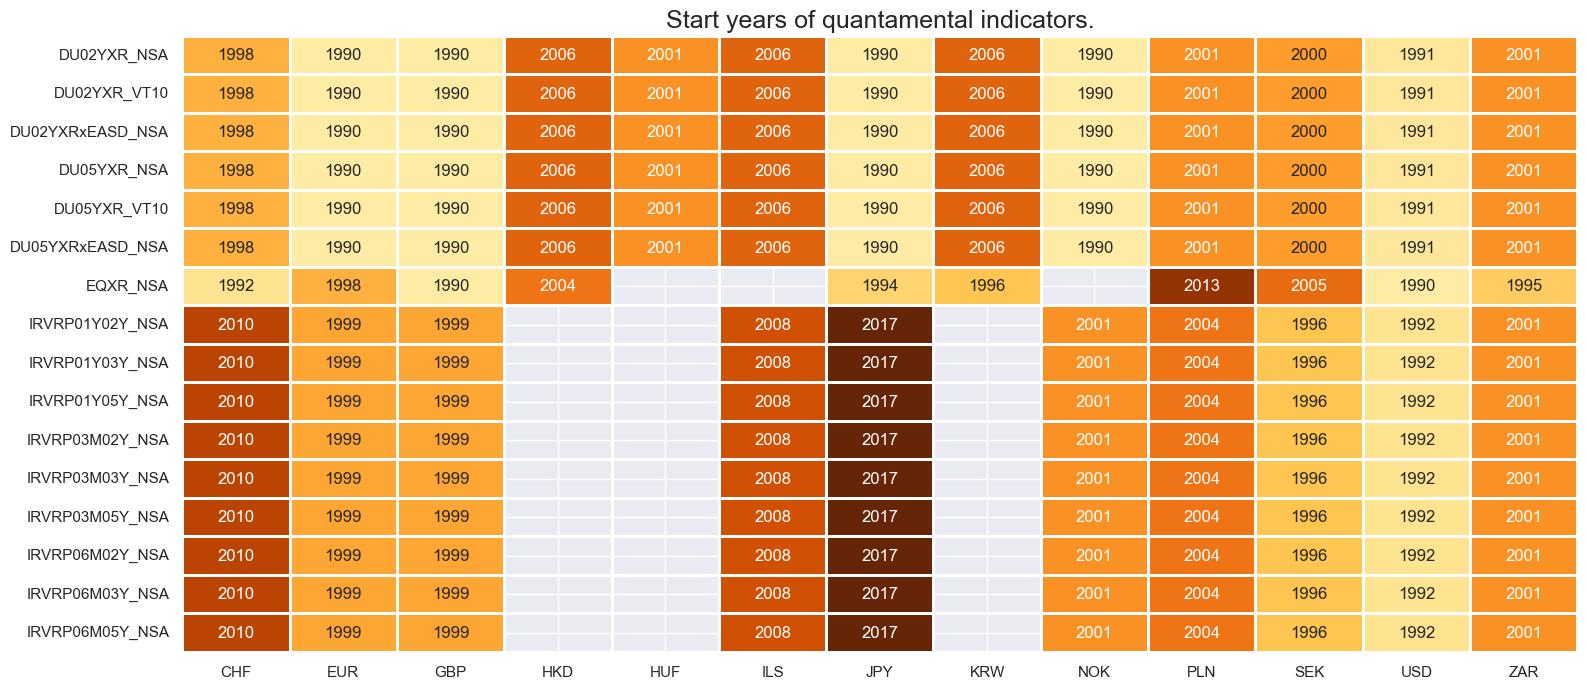

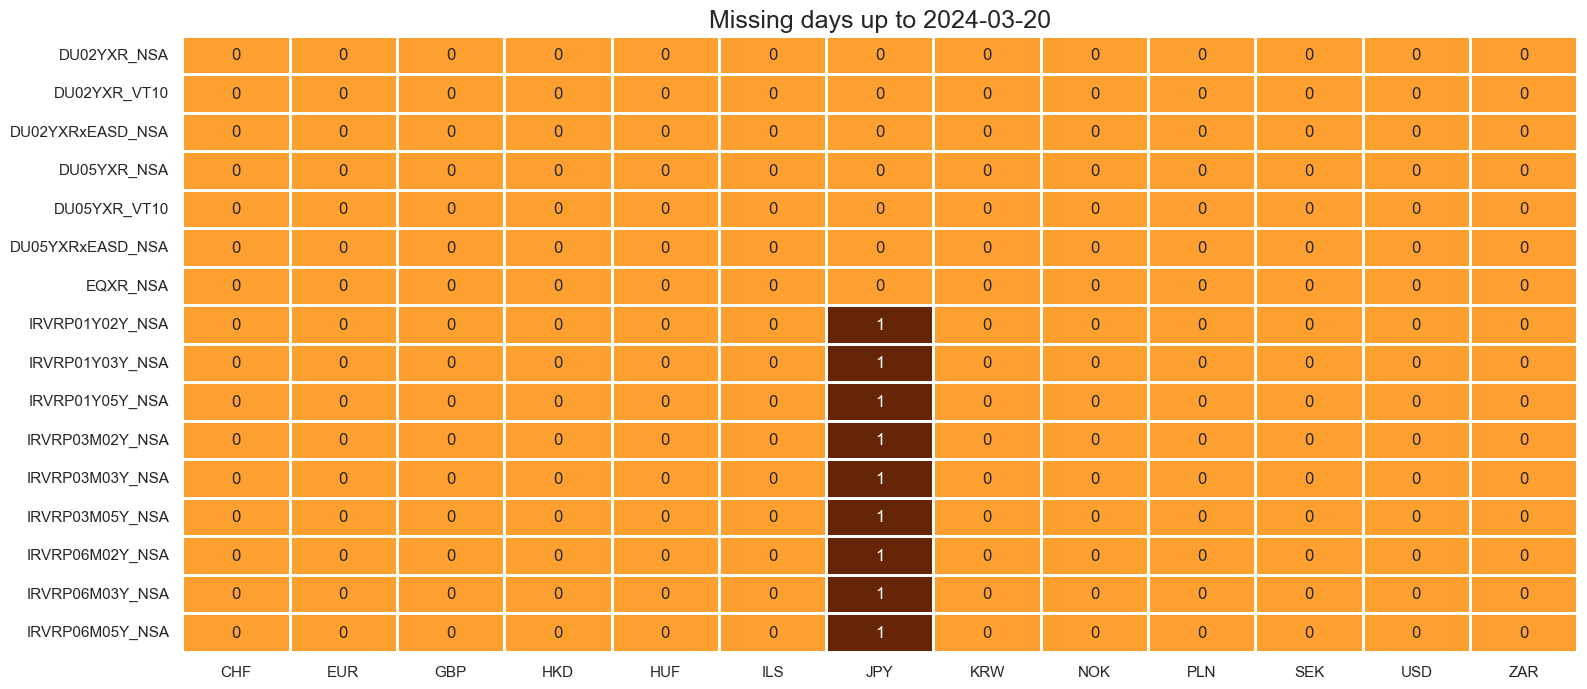

In [7]:
msm.check_availability(
    df,
    xcats=xcats,
    cids=cids_vrp,
)

### Blacklist dictionary

ZAR data was not updated March 2019 to July 2020, due to the lack of trader at J.P. Morgan, hence we create a [blacklist dictionary](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#exclude-series-sections-with-make-blacklist) and pass it to several package functions in this notebook that exclude the blacklisted period from related analyses.  

In [8]:
zar_black = ["2019-03-15", "2020-07-31"]
dv_black = {"ZAR": [pd.to_datetime(s) for s in zar_black]}
dv_black

{'ZAR': [Timestamp('2019-03-15 00:00:00'), Timestamp('2020-07-31 00:00:00')]}

## Transformations and checks

### Features

#### Volatility return premia

As the first step, part of preliminary analysis, we display volatility risk premia for 2-year and 5-year IRS receivers with swaption maturity of 3 months on the timeline as well as separately their means and standard deviations. Please see [here](https://academy.macrosynergy.com/academy/Themes/Shock%20and%20risk%20measures/_build/html/notebooks/Duration%20volatility%20risk%20premia.php?highlight=irvrp) for the definition of the indicators and [Introduction to Macrosynergy package](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) for the standard functions used throughout this notebook.

Shorter-duration VRP have been highest in economies with low short-term interest rates (which have little realized rates volatility). 

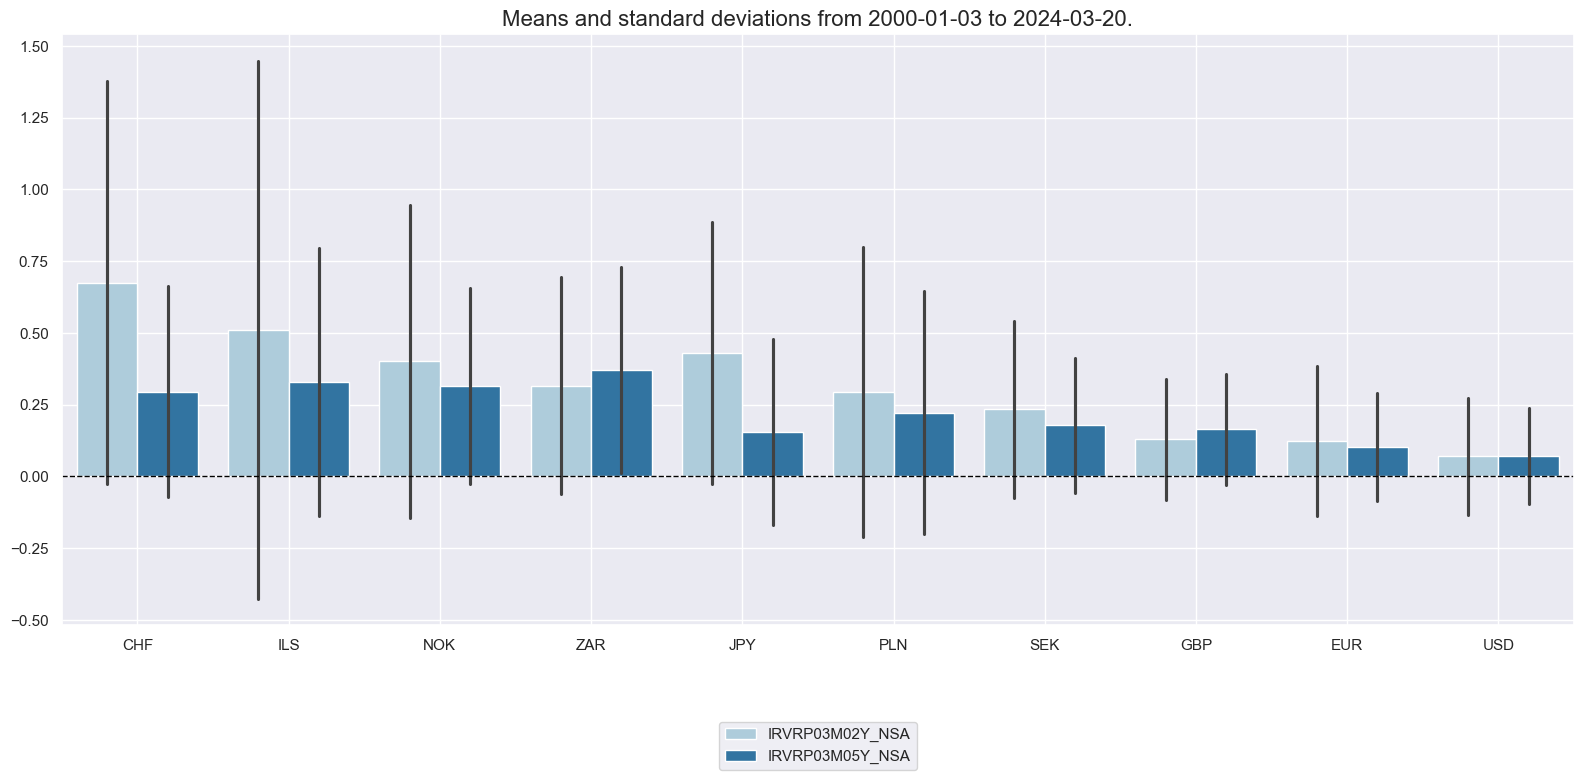

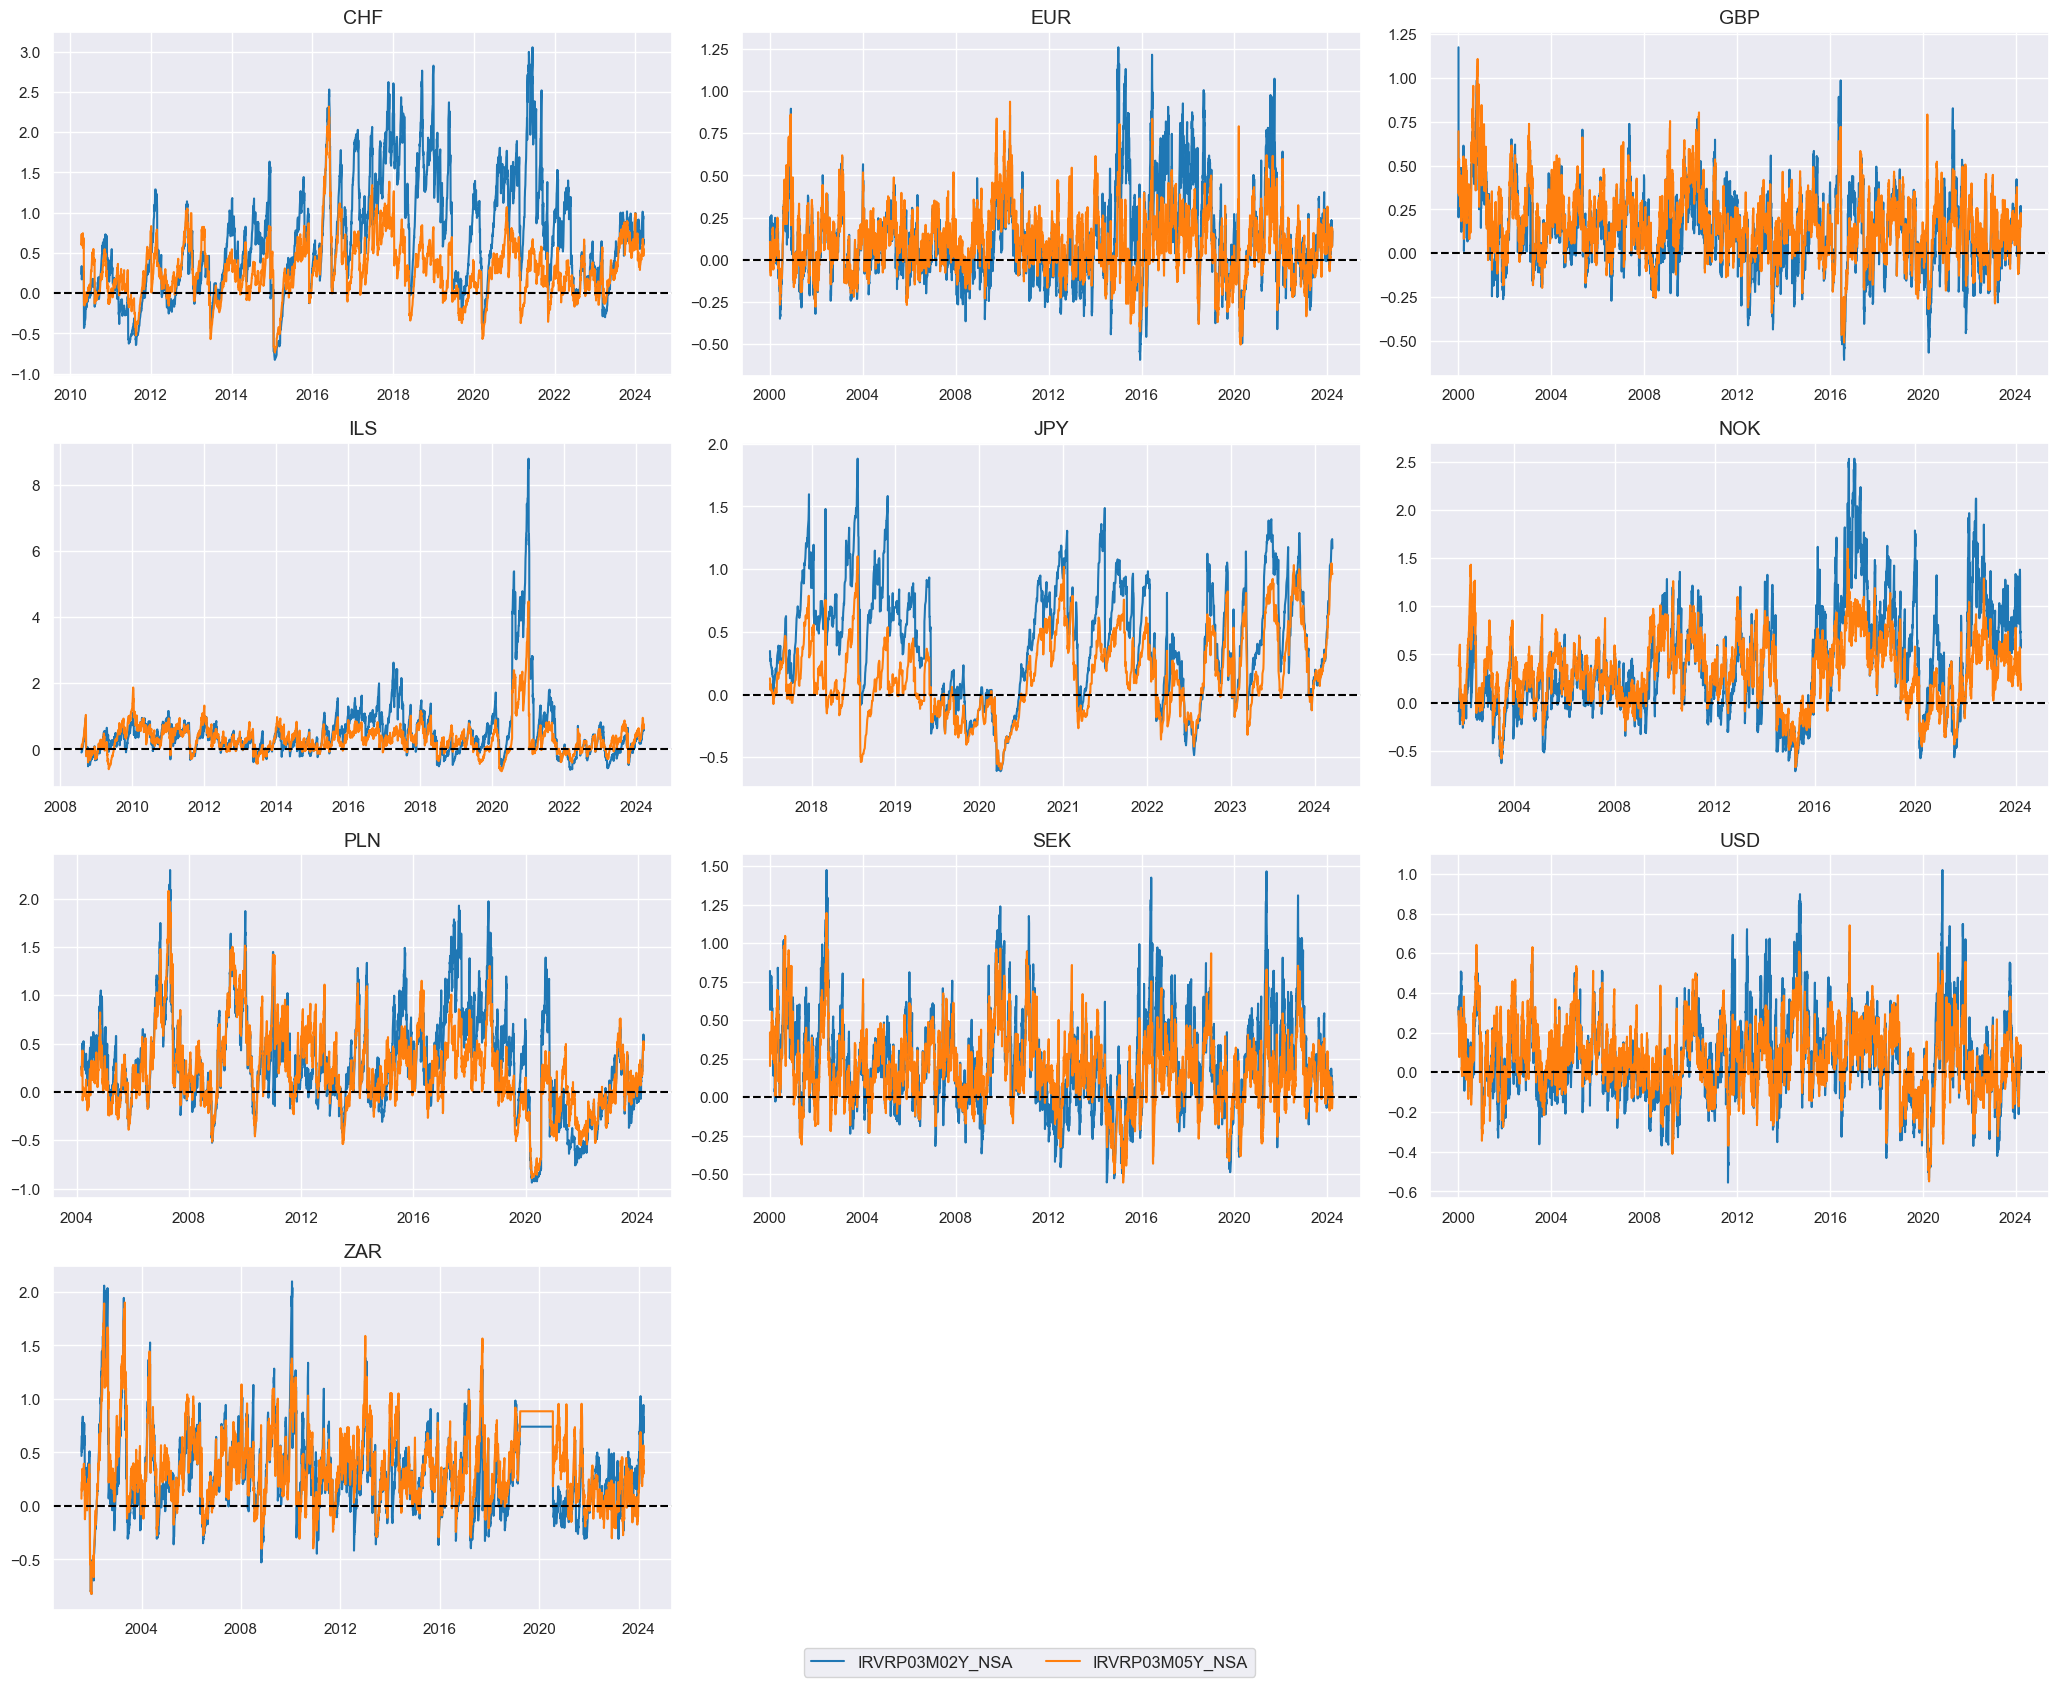

In [9]:
xcats_sel = ["IRVRP03M02Y_NSA", "IRVRP03M05Y_NSA"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title=None,
    ylab=None,
    start="2000-01-01",
)
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_vrp,
    ncol=3,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title=None,
    xcat_labels=None,
)

For most countries for 2-year duration, the VRP based on shorter-maturity options is larger than the VRP based on longer-maturity options (5 years). High current volatility is often expected to revert to its long-term average or decline over time, which can impact the relationship between long-term implied volatility and recently realized volatility. This expectation of mean reversion in volatility can influence the estimation of volatility risk premia based on longer-dated maturities. Given this understanding, incorporating both short and long-term lookbacks in estimating the expected realized measure can help provide a more accurate estimation of volatility risk premia for longer-dated maturities. 

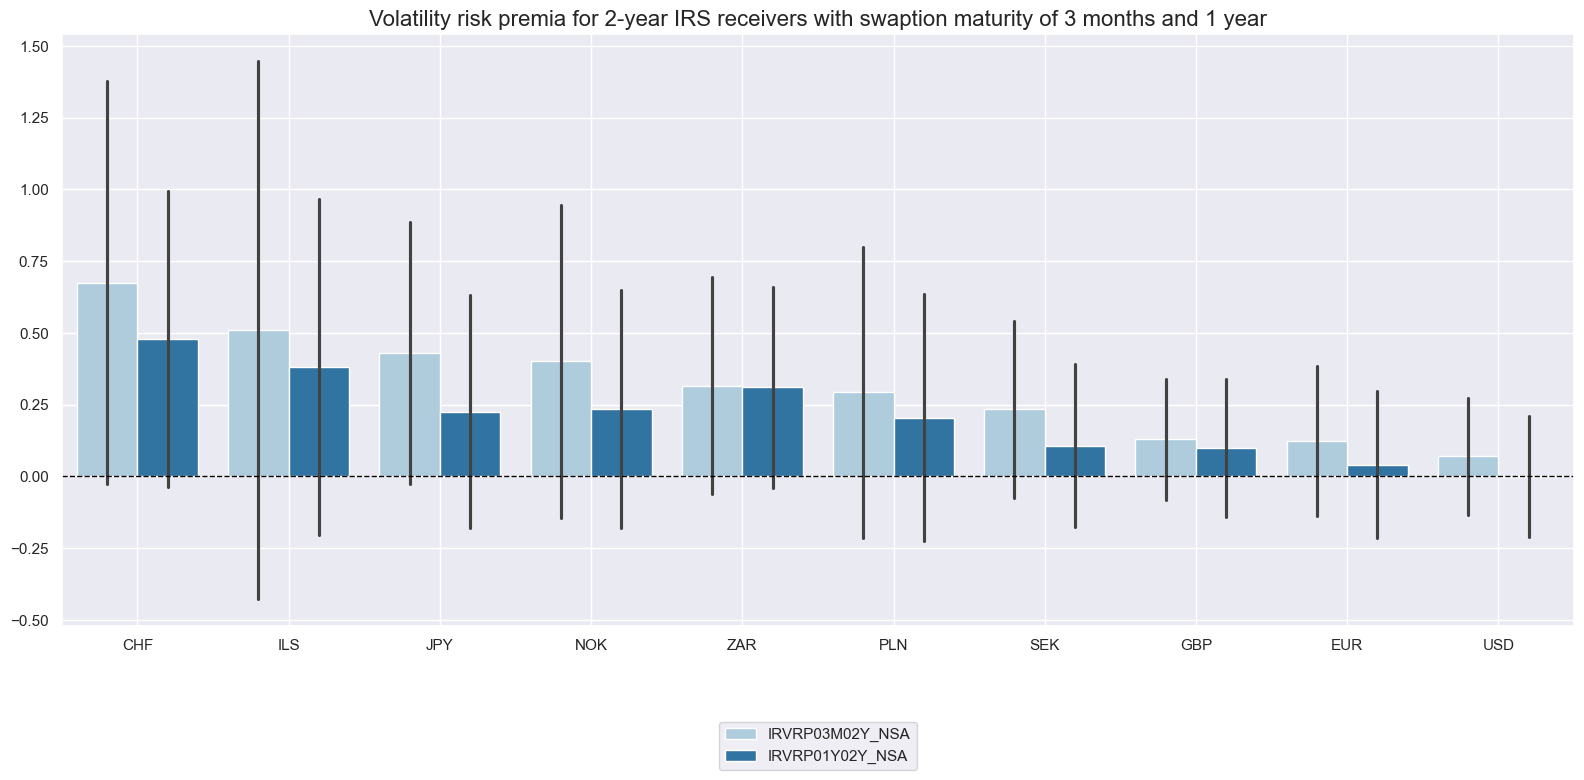

In [10]:
xcats_sel = ["IRVRP03M02Y_NSA", "IRVRP01Y02Y_NSA"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title="Volatility risk premia for 2-year IRS receivers with swaption maturity of 3 months and 1 year",
    ylab=None,
    start="2000-01-01",
)

For longer-duration IRS (5 years) the gap between short-term and longer-term maturity-based VRPs has been smaller.

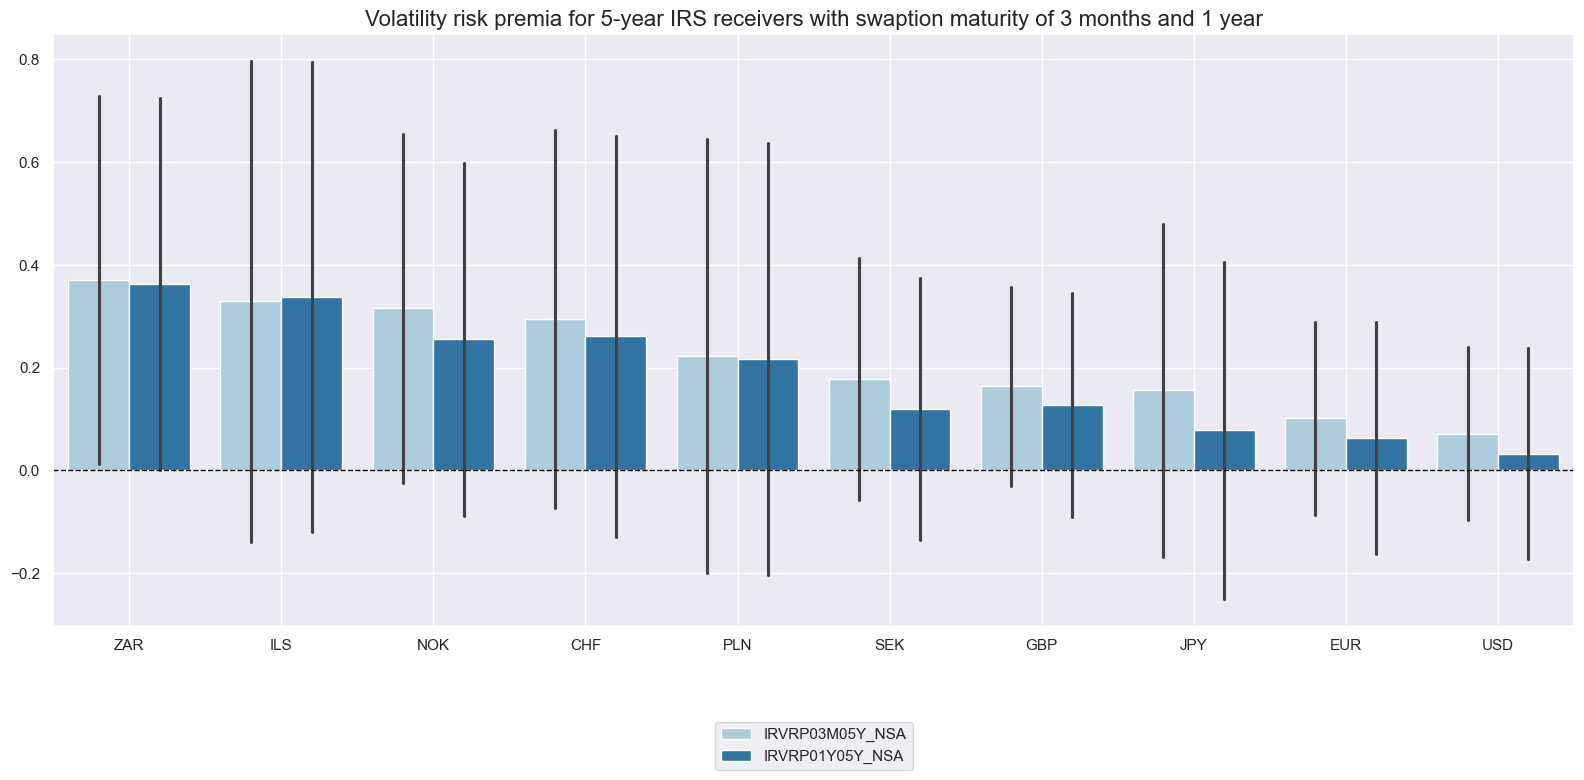

In [11]:
xcats_sel = ["IRVRP03M05Y_NSA", "IRVRP01Y05Y_NSA"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title="Volatility risk premia for 5-year IRS receivers with swaption maturity of 3 months and 1 year",
    ylab=None,
    start="2000-01-01",
)

#### Rolling means and medians

Adding a rolling average to the estimation of volatility premia can indeed introduce stability to the estimates, but it's important to note that it also introduces a time lag in capturing shifts in the premium. The code below creates a rolling 5-day average for all volatility premia categories, appending a postfix `_5DMA` to indicate the modified category.

In [12]:
calcs = []
for vrp in main:
    calc = [f"{vrp}_5DMA = {vrp}.rolling(5).mean() "]
    calcs += calc

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

For comparison, the new rolling 5-day moving average is plotted against the original series.

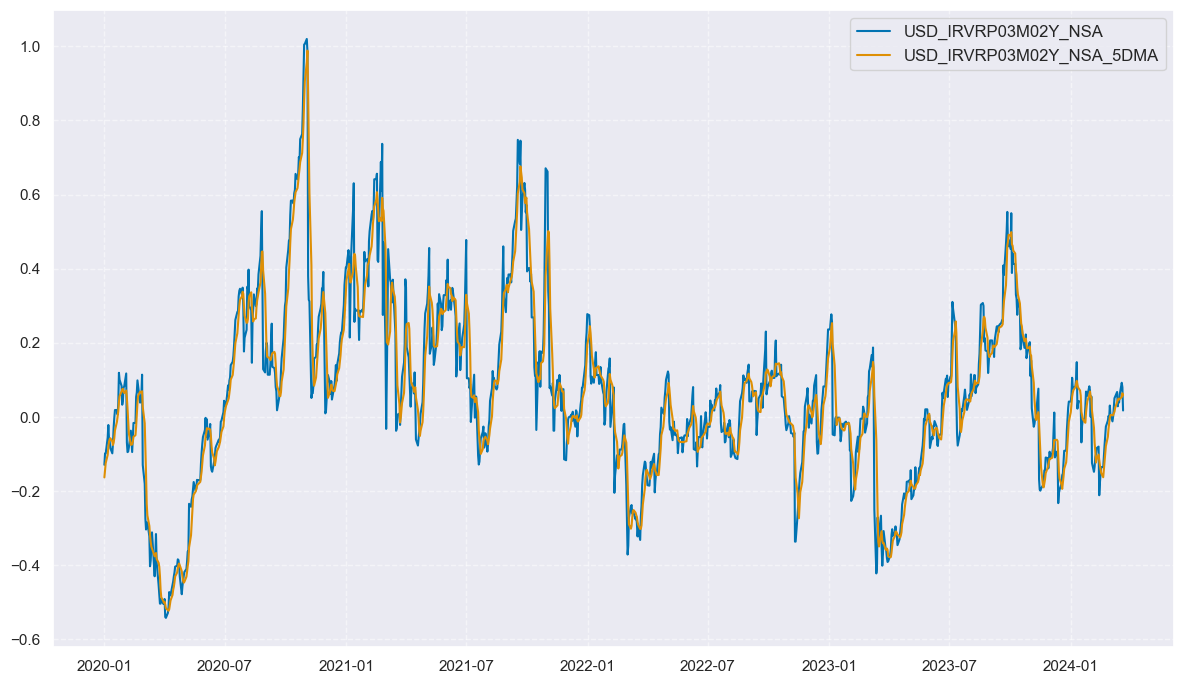

In [13]:
xcats_sel = ["IRVRP03M02Y_NSA", "IRVRP03M02Y_NSA_5DMA"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=["USD"],
    start="2020-01-01",
    title=None,
)

#### VRP averages

Simple averages of duration VRPs may be most representative of the general concept and reduce the effects of individual pricing errors. The average volatility risk premium here is based on the arithmetic average of the premium for three underlying IRS tenors (2, 3, and 5 years) and three option maturities (3, 6, and 12 months).

The cell below creates 2 types of averages for each cross-section:

`IRVRP_AVG` - represents the average of original volatility premia 
`IRVRP_5DMA_AVG` represents the average of rolling 5 days averages

In [14]:
sum_str = " + ".join((vrp for vrp in main))  # join list to string of sum
sum_str_5dma = " + ".join((vrp + "_5DMA" for vrp in main))

calc1 = f"IRVRP_AVG = ( {sum_str} ) / {len(main)}"
calc2 = f"IRVRP_5DMA_AVG = ( {sum_str_5dma} ) / {len(main)}"
calcs = [calc1] + [calc2]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

Volatility risk premia across the available sample periods have on average been positive for all countries. The highest premia were charged in Switzerland and Israel, the lowest in the U.S. and South Korea. In all countries, the premia have at least temporarily been negative.

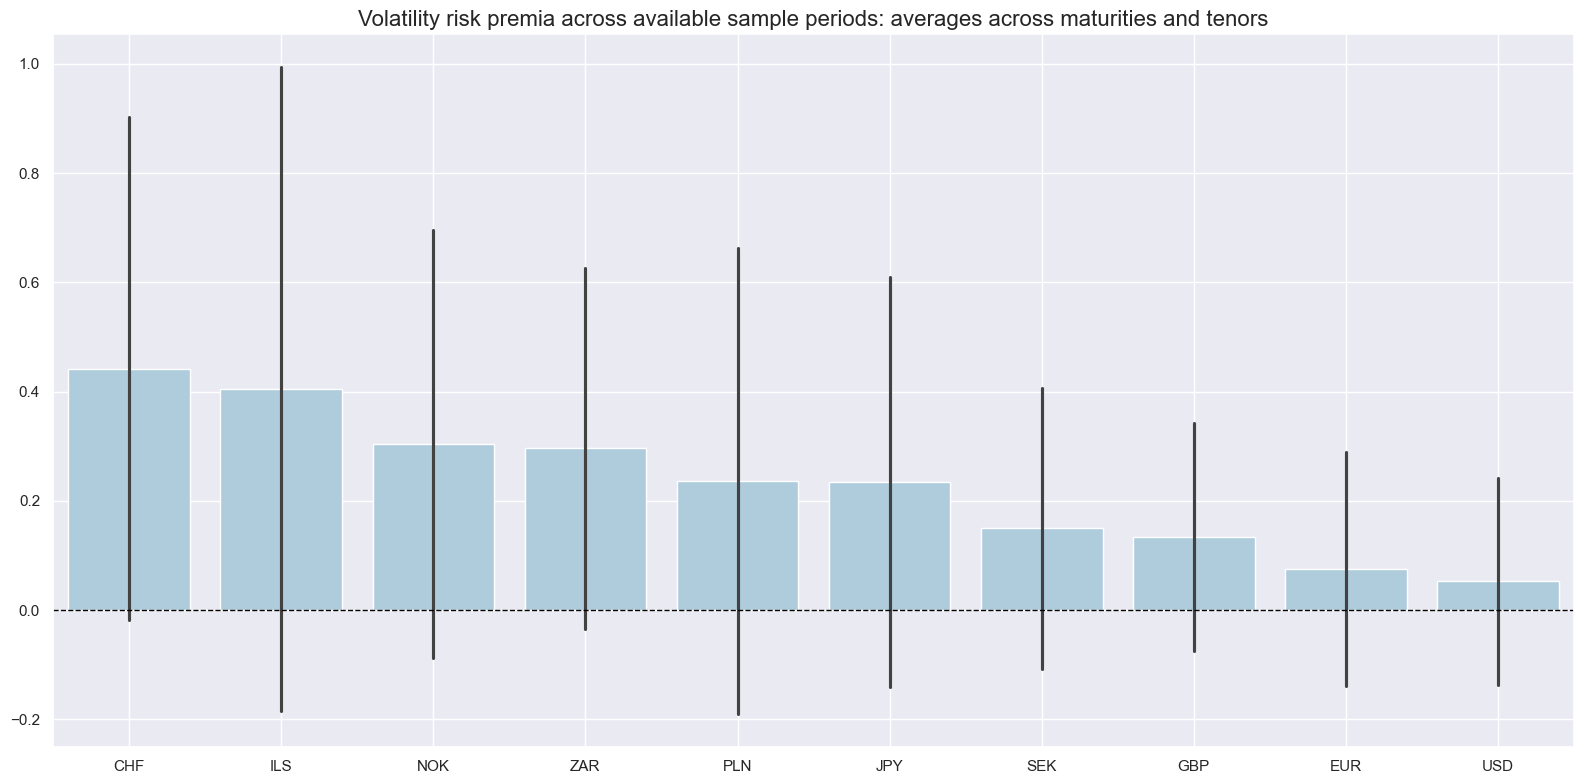

In [15]:
xcats_sel = ["IRVRP_AVG"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title="Volatility risk premia across available sample periods: averages across maturities and tenors",
    ylab=None,
    start="1992-01-01",
)

The premia have been stationarity with sustained periods of months or years above average and short periods below average or in negative territory. Beyond, there has been ample short-term volatility, even after taking 5-day moving averages.

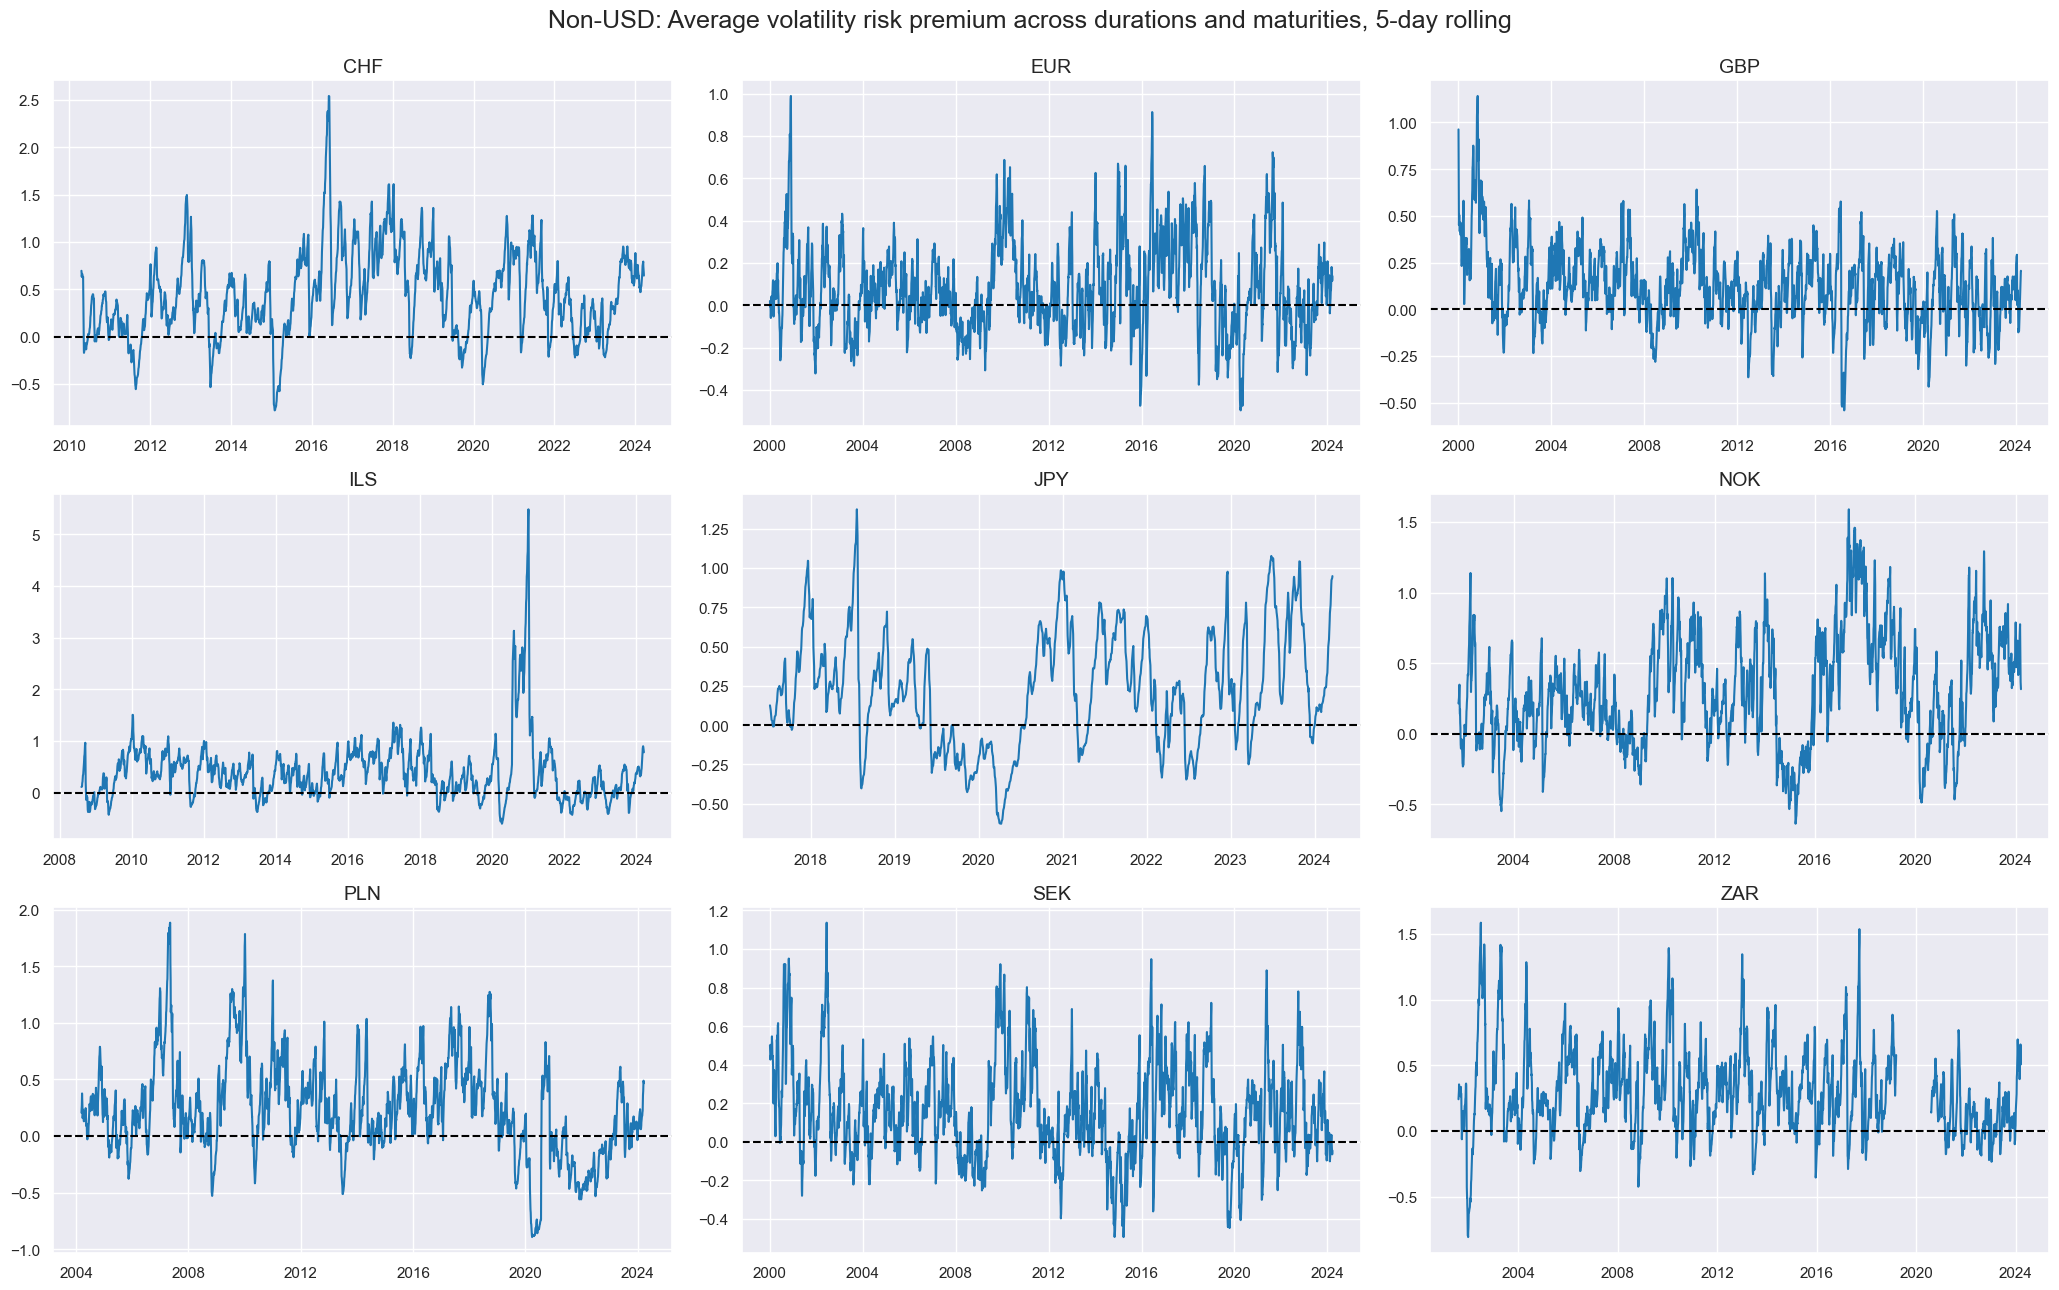

In [16]:
xcats_sel = ["IRVRP_5DMA_AVG"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_vrxu,
    ncol=3,
    cumsum=False,
    start="2000-01-01",
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title="Non-USD: Average volatility risk premium across durations and maturities, 5-day rolling",
    xcat_labels=None,
)

U.S. data are now available for three decades and reveal pronounced and sustained phases of negative and positive premia.

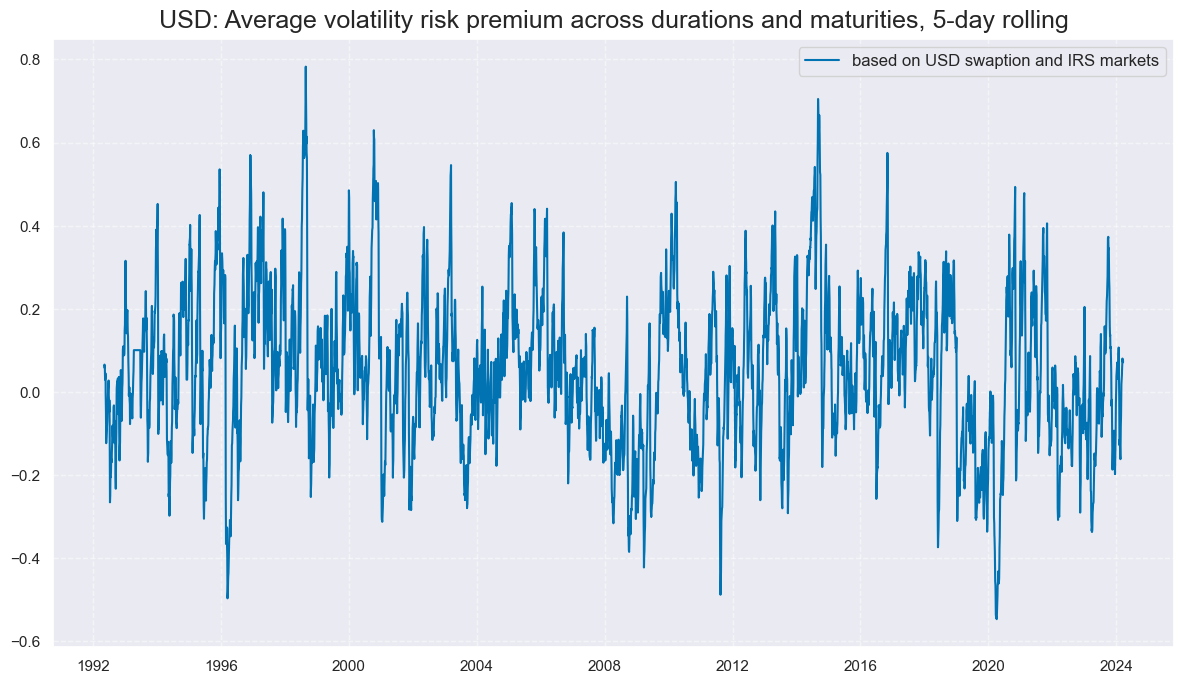

In [17]:
xcats_sel = ["IRVRP_5DMA_AVG"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=["USD"],
    start="1992-01-01",
    title="USD: Average volatility risk premium across durations and maturities, 5-day rolling",
    xcat_labels=["based on USD swaption and IRS markets"],
)

Volatility risk premia have been positively correlated across all markets, based on the longest common samples. This suggests that they reflect common global factors.

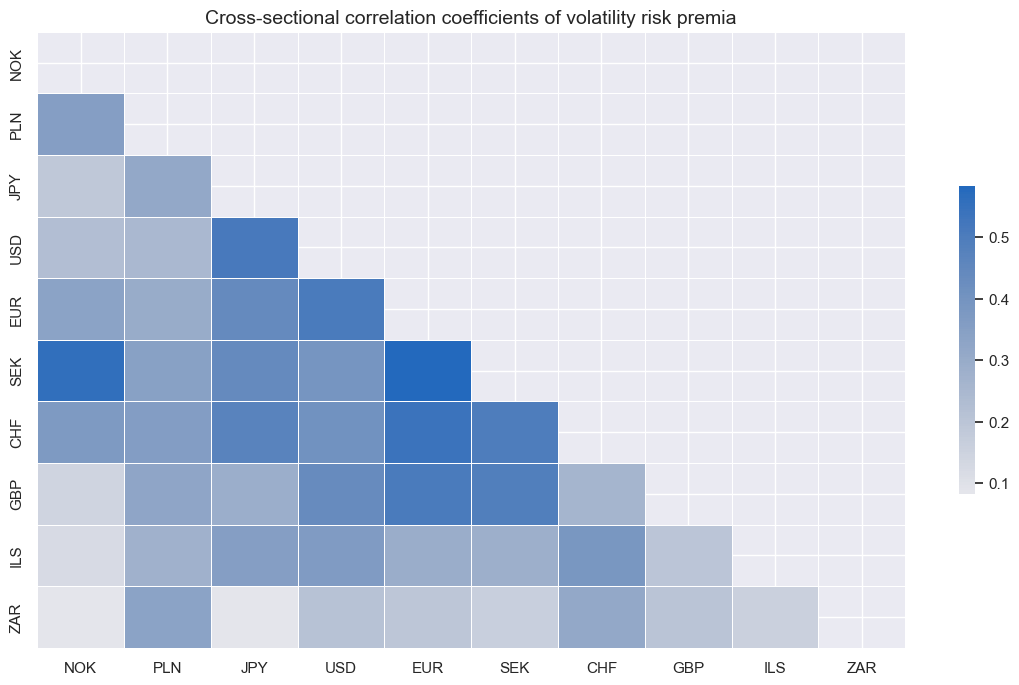

In [18]:
msp.correl_matrix(
    dfx,
    xcats="IRVRP_5DMA_AVG",
    cids=cids_vrp,
    start="2000-01-01",
    cluster=True,
    title="Cross-sectional correlation coefficients of volatility risk premia",
)

#### VRP term spreads

Here term spread refers to the difference between 5-year and 2-year IRS duration VRPs for the same option maturity. Conceptually, this refers to the difference in premia for bearing long-term uncertainty versus short-term uncertainty. 

The effective spread serves as an indicator of the dominance of either structural uncertainty (resulting in a positive spread) or cyclical uncertainty (resulting in a negative spread). Structural uncertainty refers to factors related to the overall economic or financial structure, such as long-term economic trends, systemic risks, or policy uncertainties. Cyclical uncertainty, on the other hand, relates to short-term economic fluctuations, business cycles, or market sentiment.

The next cell calculates term spreads and creates a new category by appending a postfix `_TS` to the original category.

In [19]:
omats = ["03M", "06M", "01Y"]

calcs = []
for omat in omats:  # term spreads across option maturities
    calc1 = [f"IRVRP_TS{omat} = IRVRP{omat}05Y_NSA - IRVRP{omat}02Y_NSA"]
    calc2 = [f"IRVRP_TS{omat}_5DMA = IRVRP{omat}05Y_NSA_5DMA - IRVRP{omat}02Y_NSA_5DMA"]
    calcs += calc1 + calc2


dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

It is useful to calculate an average over the three option maturities. The new indicator gets the postfix `_AVG` in addition to `_TS`

In [20]:
sum_str = " + ".join((f"IRVRP_TS{omat}" for omat in omats))
sum_str_5dma = " + ".join((f"IRVRP_TS{omat}_5DMA" for omat in omats))

calc1 = f"IRVRP_TS_AVG = ( {sum_str} ) / {len(omats)}"
calc2 = f"IRVRP_TS_5DMA_AVG = ( {sum_str_5dma} ) / {len(omats)}"
calcs = [calc1] + [calc2]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

Historically, the term spread has been mostly negative, i.e. premia for taking short-duration volatility risk have been higher than for taking long-duration volatility risk.
This may be an indication that interest rates in most countries are seen as more anchored in the long run than in the short run.

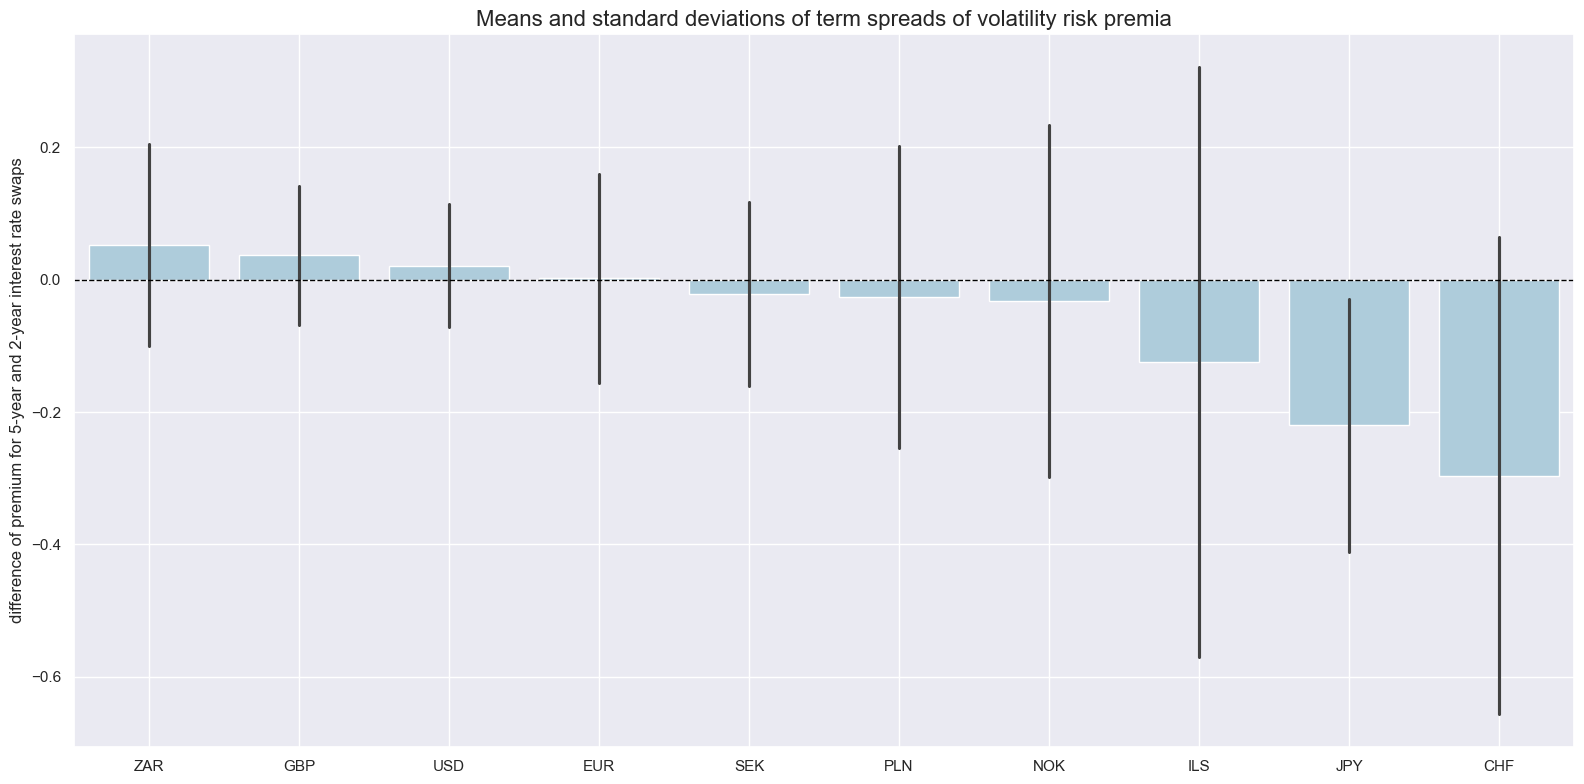

In [21]:
xcats_sel = ["IRVRP_TS_5DMA_AVG"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title="Means and standard deviations of term spreads of volatility risk premia",
    ylab="difference of premium for 5-year and 2-year interest rate swaps",
    start="2000-01-01",
)

Over time, the spreads have displayed trends, cycles, and ample short-term volatility. Here we display the timeline of US term spreads of volatility risk premia, 5 day rolling mean (US has the longest history of data, available singe 1992)

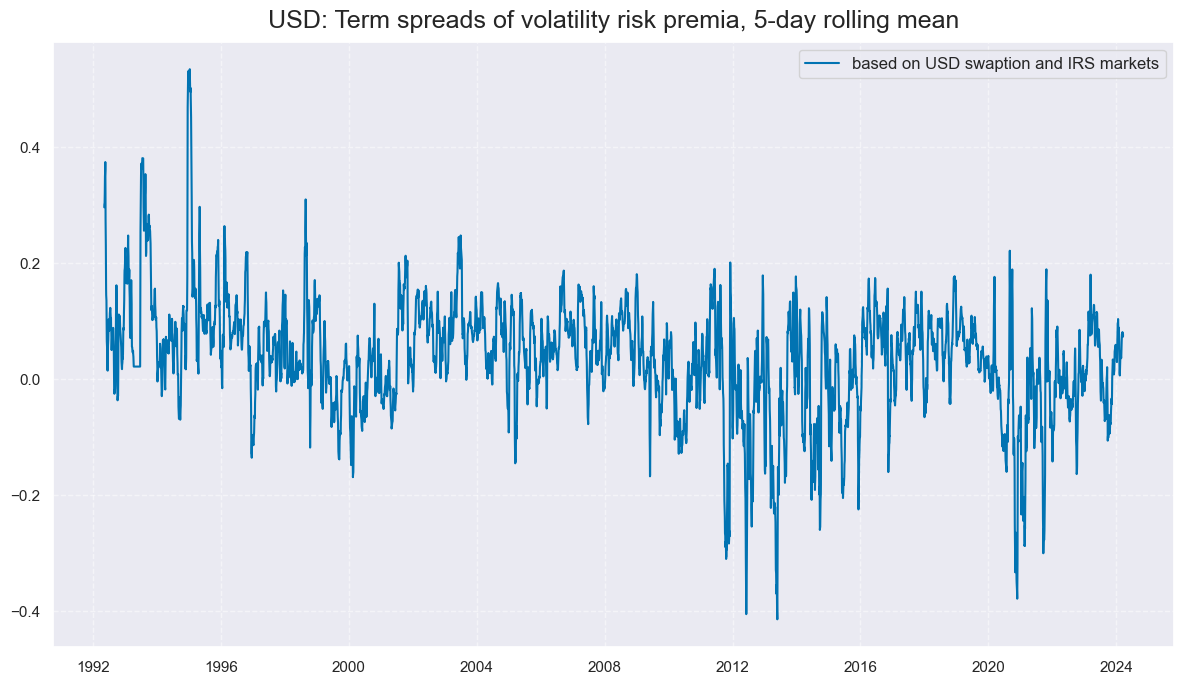

In [22]:
xcats_sel = ["IRVRP_TS_5DMA_AVG"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=["USD"],
    start="1992-01-01",
    title_adj=1.01,
    title="USD: Term spreads of volatility risk premia, 5-day rolling mean",
    xcat_labels=["based on USD swaption and IRS markets"],
)

Correlations of term spreads across economies have been mixed. In particular, USD term spread correlation with other countries has been mostly negative. However, the correlation of term spreads for the European countries has been mostly positive.

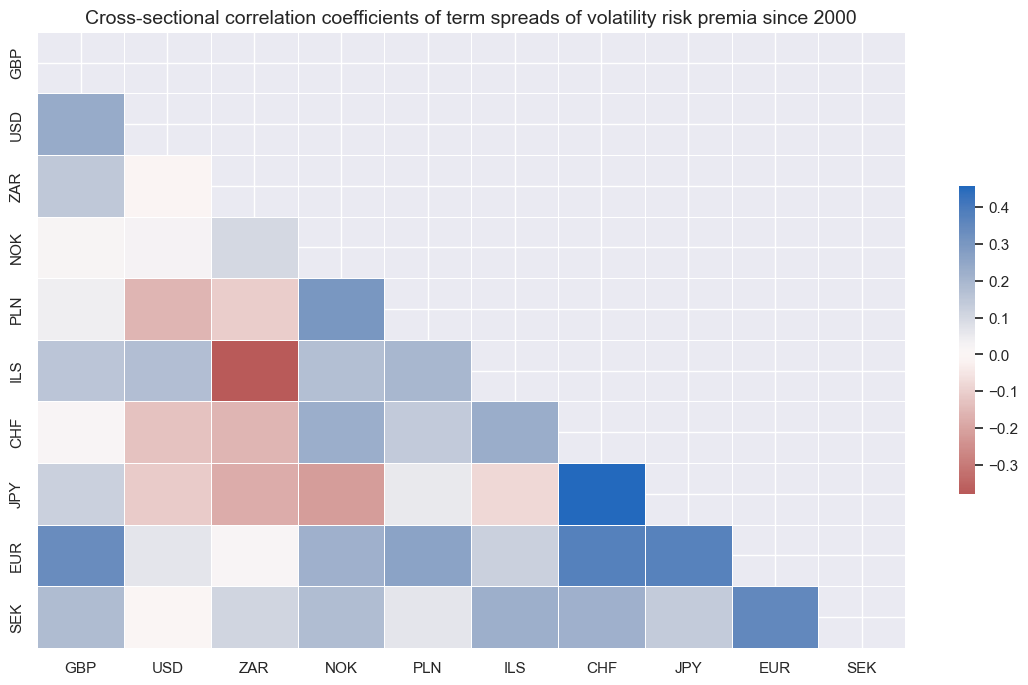

In [23]:
msp.correl_matrix(
    dfx,
    xcats="IRVRP_TS_5DMA_AVG",
    cids=cids_vrp,
    start="2000-01-01",
    cluster=True,
    title="Cross-sectional correlation coefficients of term spreads of volatility risk premia since 2000",
)

#### VRP maturity spreads

#### Directional

Here maturity spread means the difference between the VRP based on a longer-maturity option compared to a shorter-maturity option, for the same underlying duration.
Since realized volatility for both is estimated in the same day this is equivalent to the scaled difference between implied vols of the 1-year and 3-month options for the same maturity. This may give an indication if volatility is expected to be persistent (positive spread) or short-lived (negative spread).

In [24]:
durs = ["02Y", "03Y", "05Y"]

calcs = []
for dur in durs:  # term spreads across option maturities
    calc1 = [f"IRVRP_MS{dur} = IRVRP01Y{dur}_NSA - IRVRP03M{dur}_NSA"]
    calc2 = [f"IRVRP_MS{dur}_5DMA = IRVRP01Y{dur}_NSA_5DMA - IRVRP03M{dur}_NSA_5DMA"]
    calcs += calc1 + calc2


dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

An average maturity spread is simply the mean overall underlying durations.

In [25]:
sum_str = " + ".join((f"IRVRP_MS{dur}" for dur in durs))
sum_str_5dma = " + ".join((f"IRVRP_MS{dur}_5DMA" for dur in durs))

calc1 = f"IRVRP_MS_AVG = ( {sum_str} ) / {len(durs)}"
calc2 = f"IRVRP_MS_5DMA_AVG = ( {sum_str_5dma} ) / {len(durs)}"
calcs = [calc1] + [calc2]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

Maturity spreads have been mostly negative and displayed very different standard deviations across currency areas with larger countries posting smaller fluctuations.

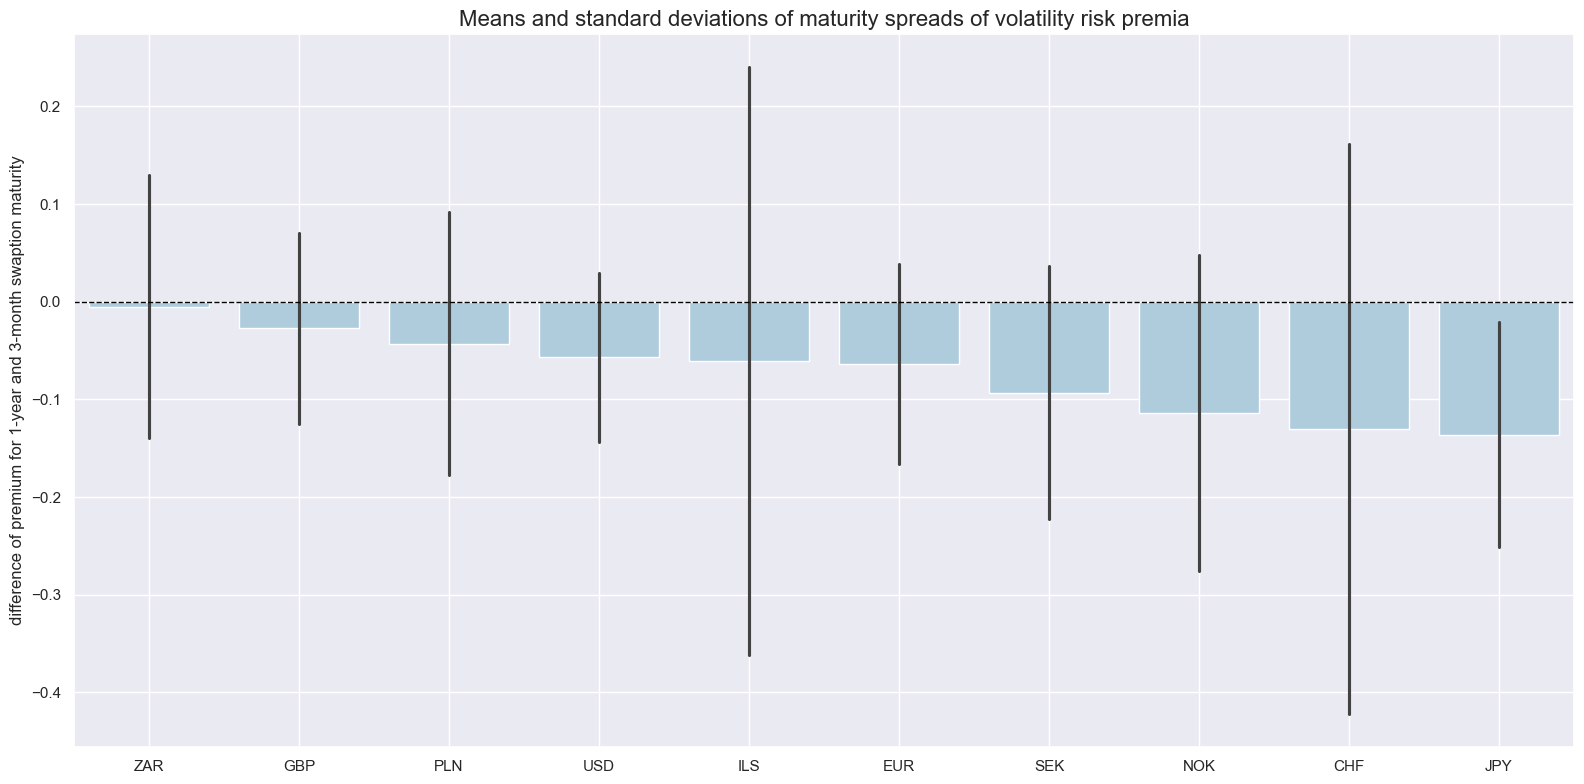

In [26]:
xcats_sel = ["IRVRP_MS_5DMA_AVG"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title="Means and standard deviations of maturity spreads of volatility risk premia",
    ylab="difference of premium for 1-year and 3-month swaption maturity",
    start="2000-01-01",
)

The time series of maturity spreads have been stationary with pronounced cycles around a negative mean, as exemplified by the U.S. history in the graph below:

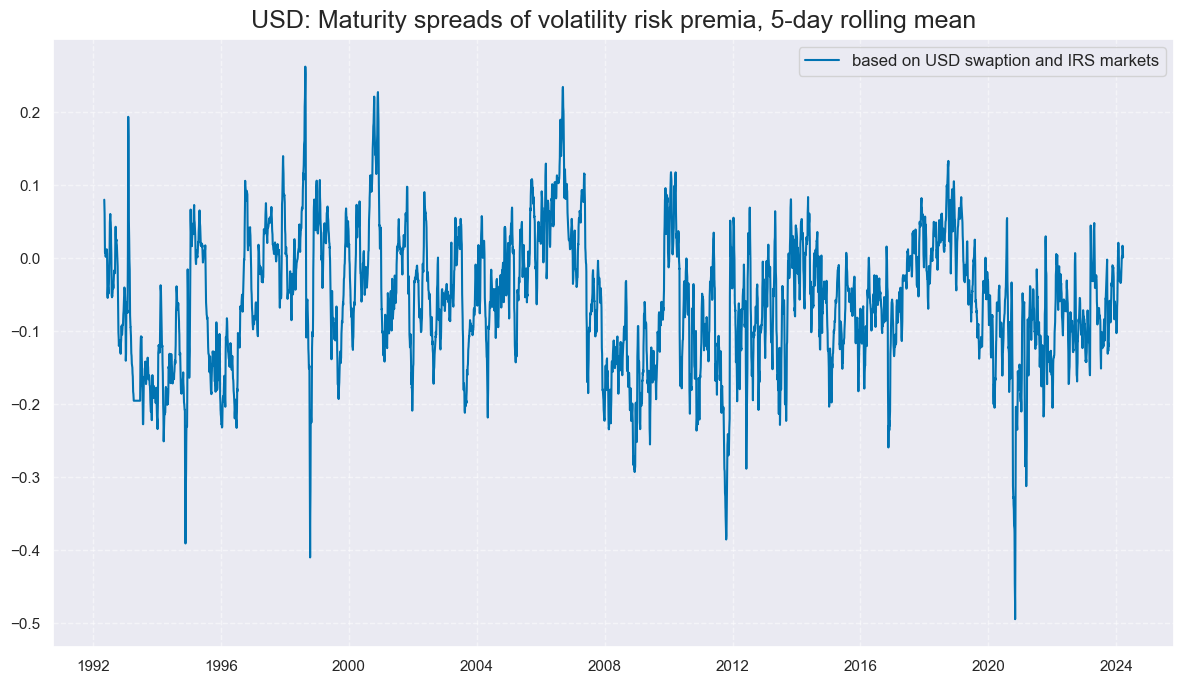

In [27]:
xcats_sel = ["IRVRP_MS_5DMA_AVG"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=["USD"],
    start="1992-01-01",
    title="USD: Maturity spreads of volatility risk premia, 5-day rolling mean",
    xcat_labels=["based on USD swaption and IRS markets"],
)

The short-duration maturity spreads turned out to be the most negative. JPY, HKD and CHF have been the countries with the deepest negative maturity spreads for 2-year durations.

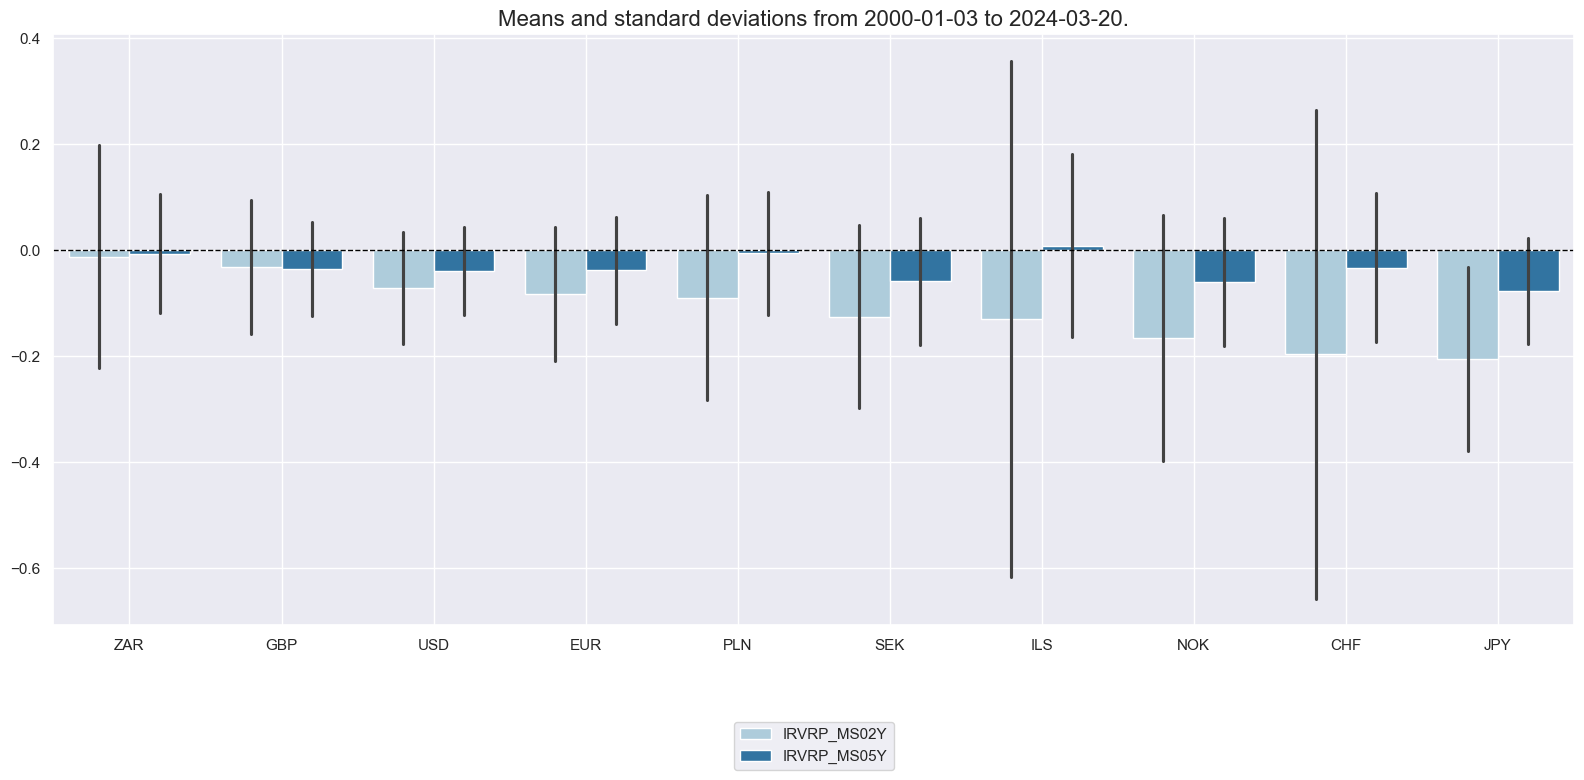

In [28]:
xcats_sel = ["IRVRP_MS02Y", "IRVRP_MS05Y"]
msp.view_ranges(
    dfx,
    cids=cids_vrp,
    xcats=xcats_sel,
    kind="bar",
    sort_cids_by="mean",
    title=None,
    ylab=None,
    start="2000-01-01",
)

Correlations across currency areas are mixed. Most post positive correlation with either the U.S. or the Euro area.

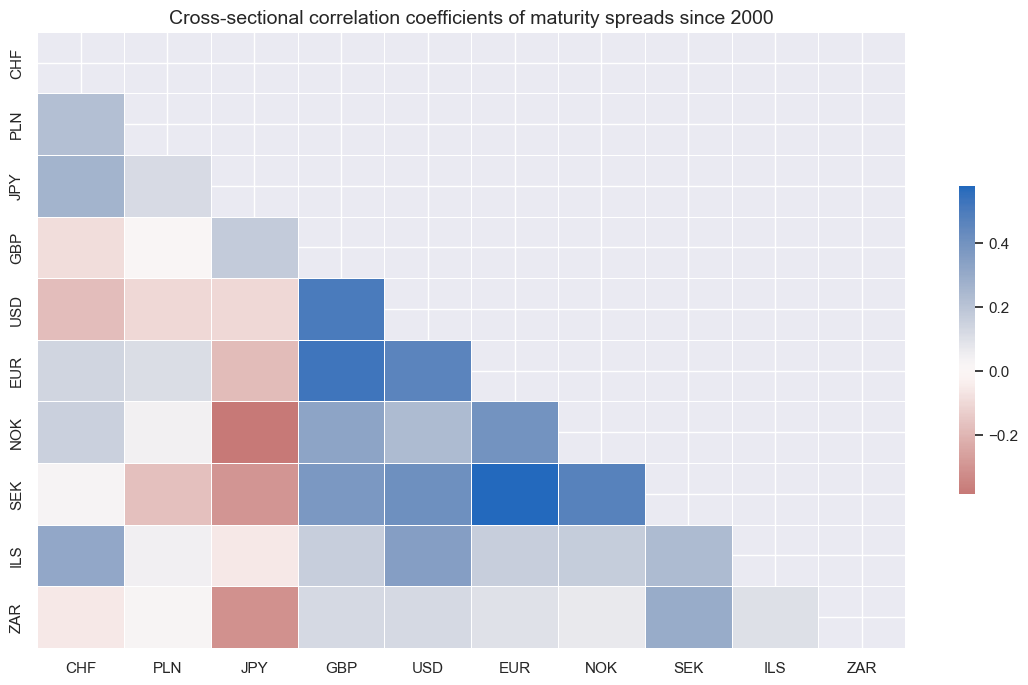

In [29]:
msp.correl_matrix(
    dfx,
    xcats="IRVRP_MS_5DMA_AVG",
    cids=cids_vrp,
    start="2000-01-01",
    cluster=True,
    title="Cross-sectional correlation coefficients of maturity spreads since 2000",
)

### Targets

#### Outright returns

Outright returns and vol-targeted returns across currency areas have shown similar cyclical patterns.

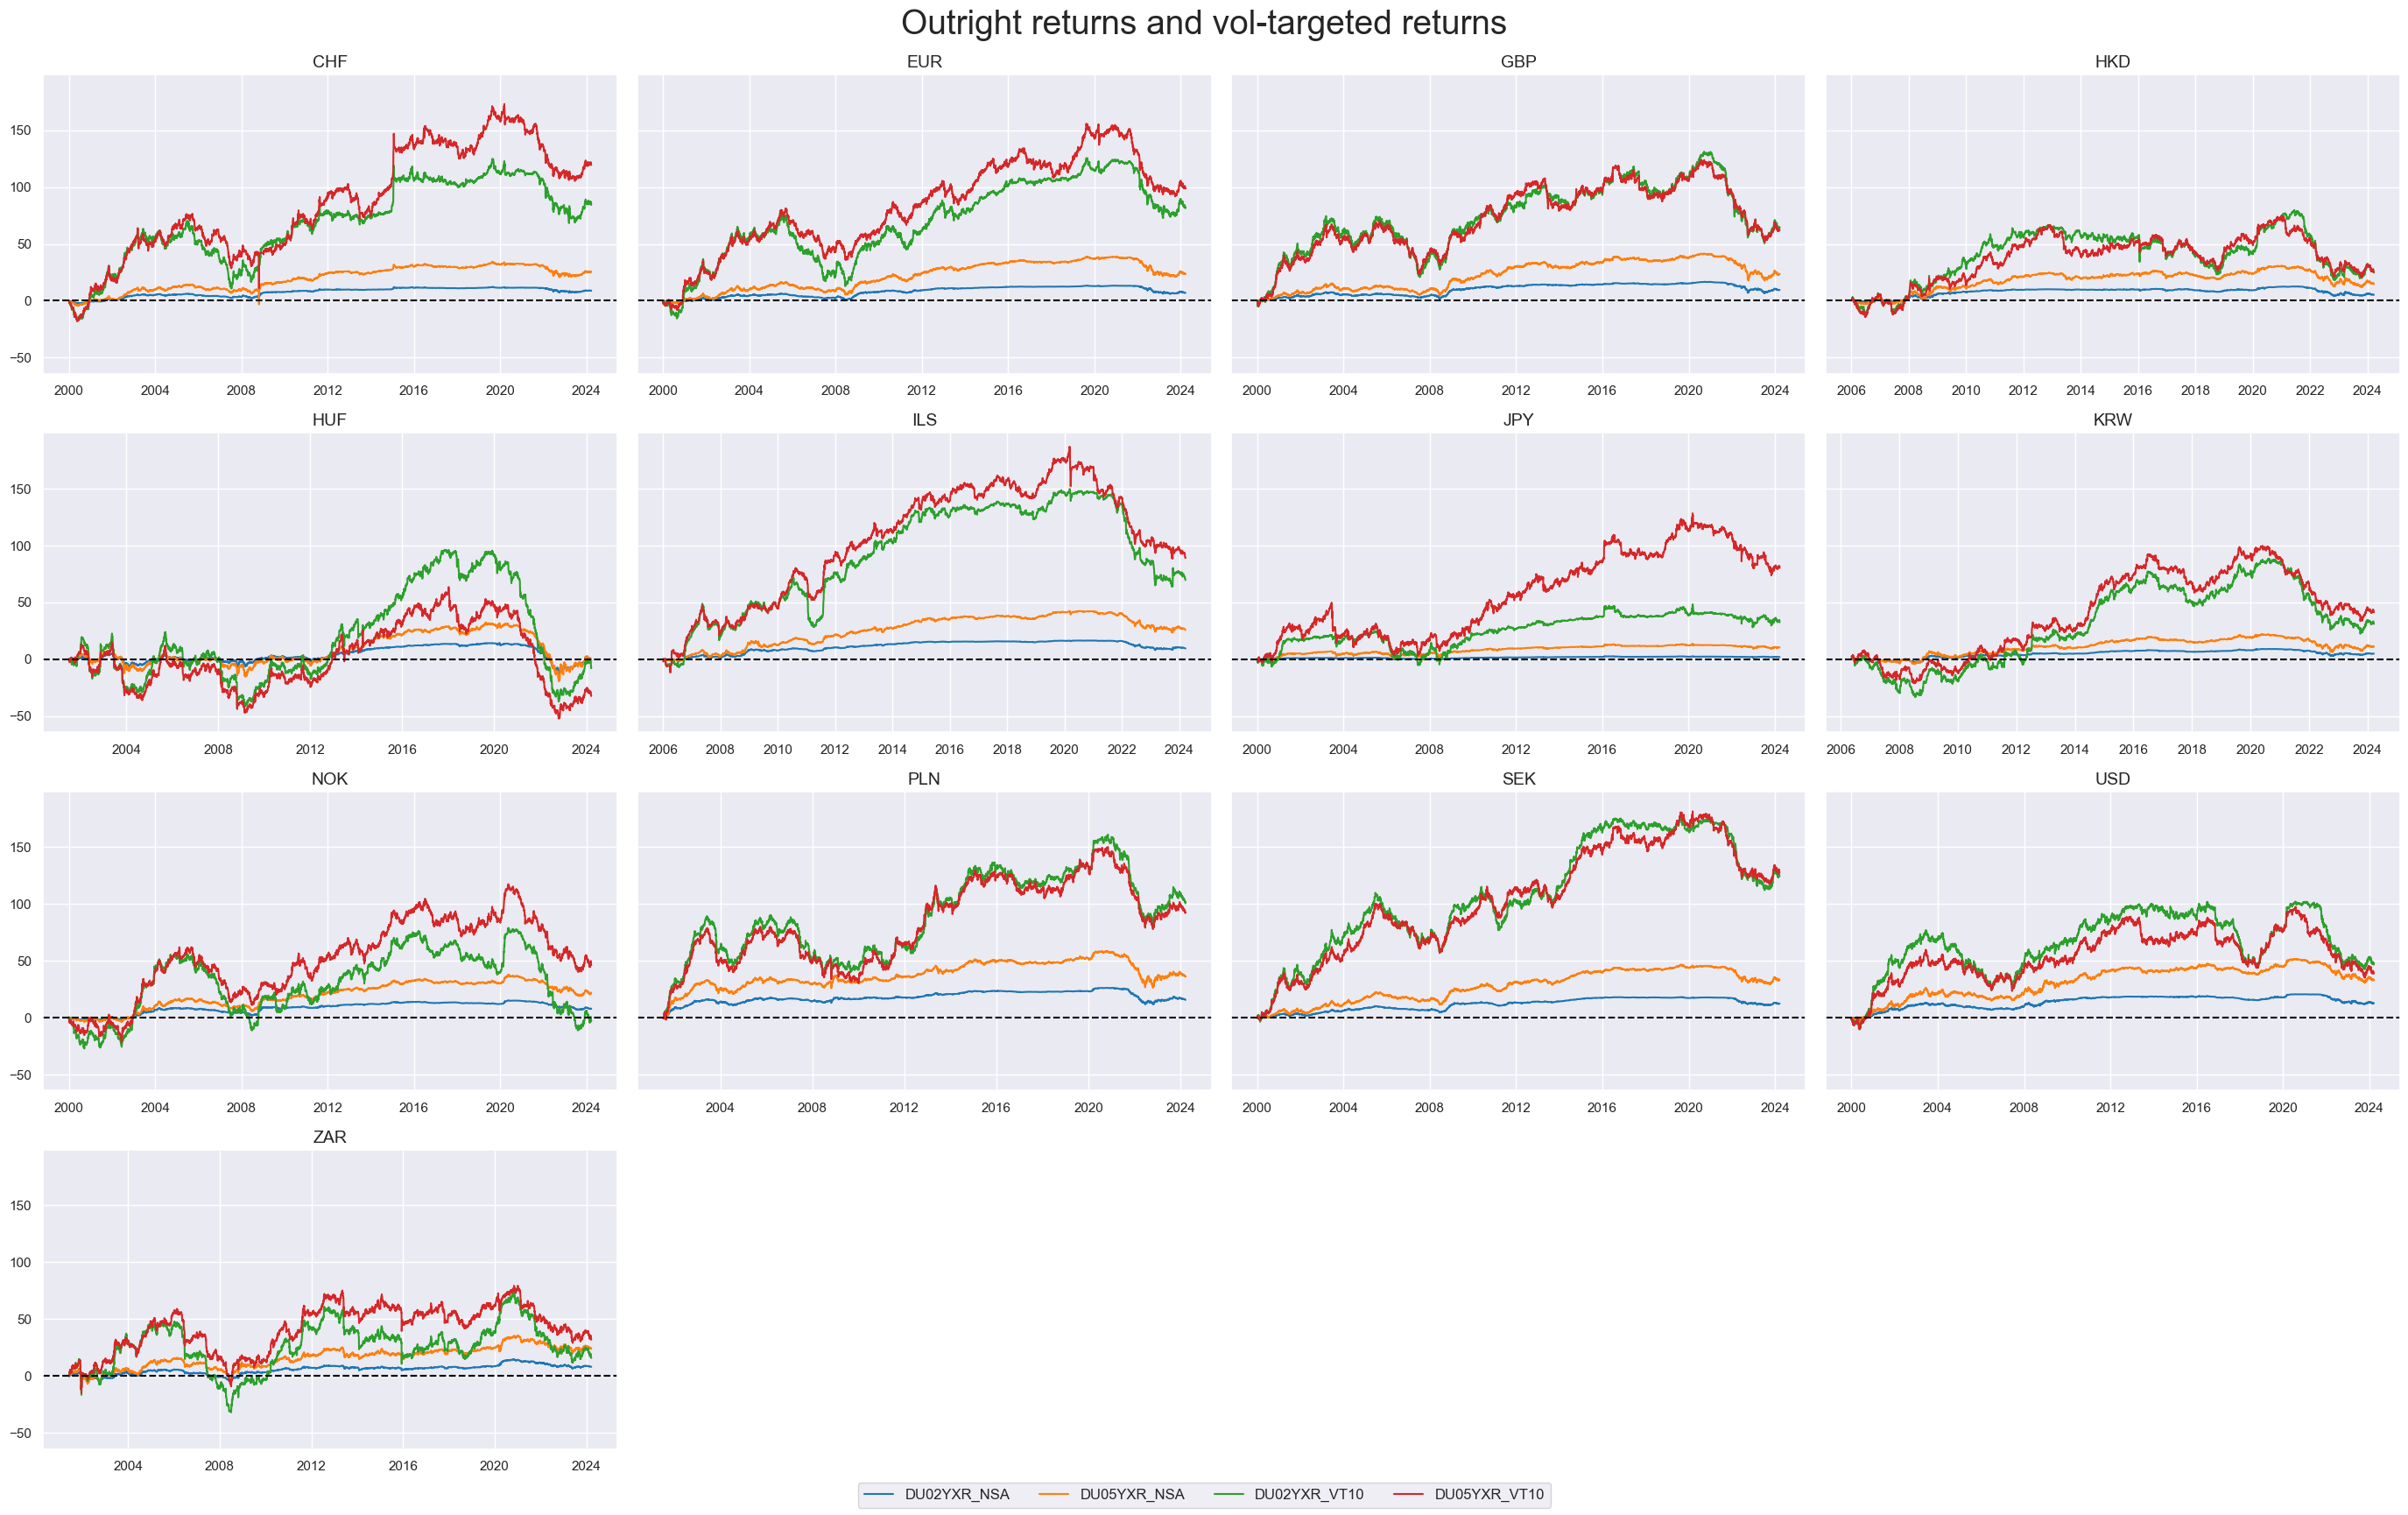

In [30]:
xcats_sel = ["DU02YXR_NSA", "DU05YXR_NSA", "DU02YXR_VT10", "DU05YXR_VT10"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_vrp,
    ncol=4,
    cumsum=True,
    start="2000-01-01",
    same_y=True,
    size=(12, 12),
    all_xticks=True,
    title="Outright returns and vol-targeted returns",
    xcat_labels=None,
    title_fontsize=28
)

#### Relative vol-parity returns (across durations and versus USD)

This relative return is the 5-year IRS receiver return minus the 2-year IRS receiver return, both based on vol-targeted positions.

In [31]:
calc1 = "DU5v2YXR = DU05YXR_VT10 - DU02YXR_VT10"
calc2 = "DU02YvUSDXR = DU02YXR_VT10 - iUSD_DU02YXR_VT10"
calc3 = "DU05YvUSDXR = DU05YXR_VT10 - iUSD_DU05YXR_VT10"
calcs = [calc1, calc2, calc3]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_vrp, blacklist=dv_black)
dfx = msm.update_df(dfx, dfa)

While cumulative returns of curve trades have posted local trends and cycles, only CHF, JPY and NOK posted longer-term drifts

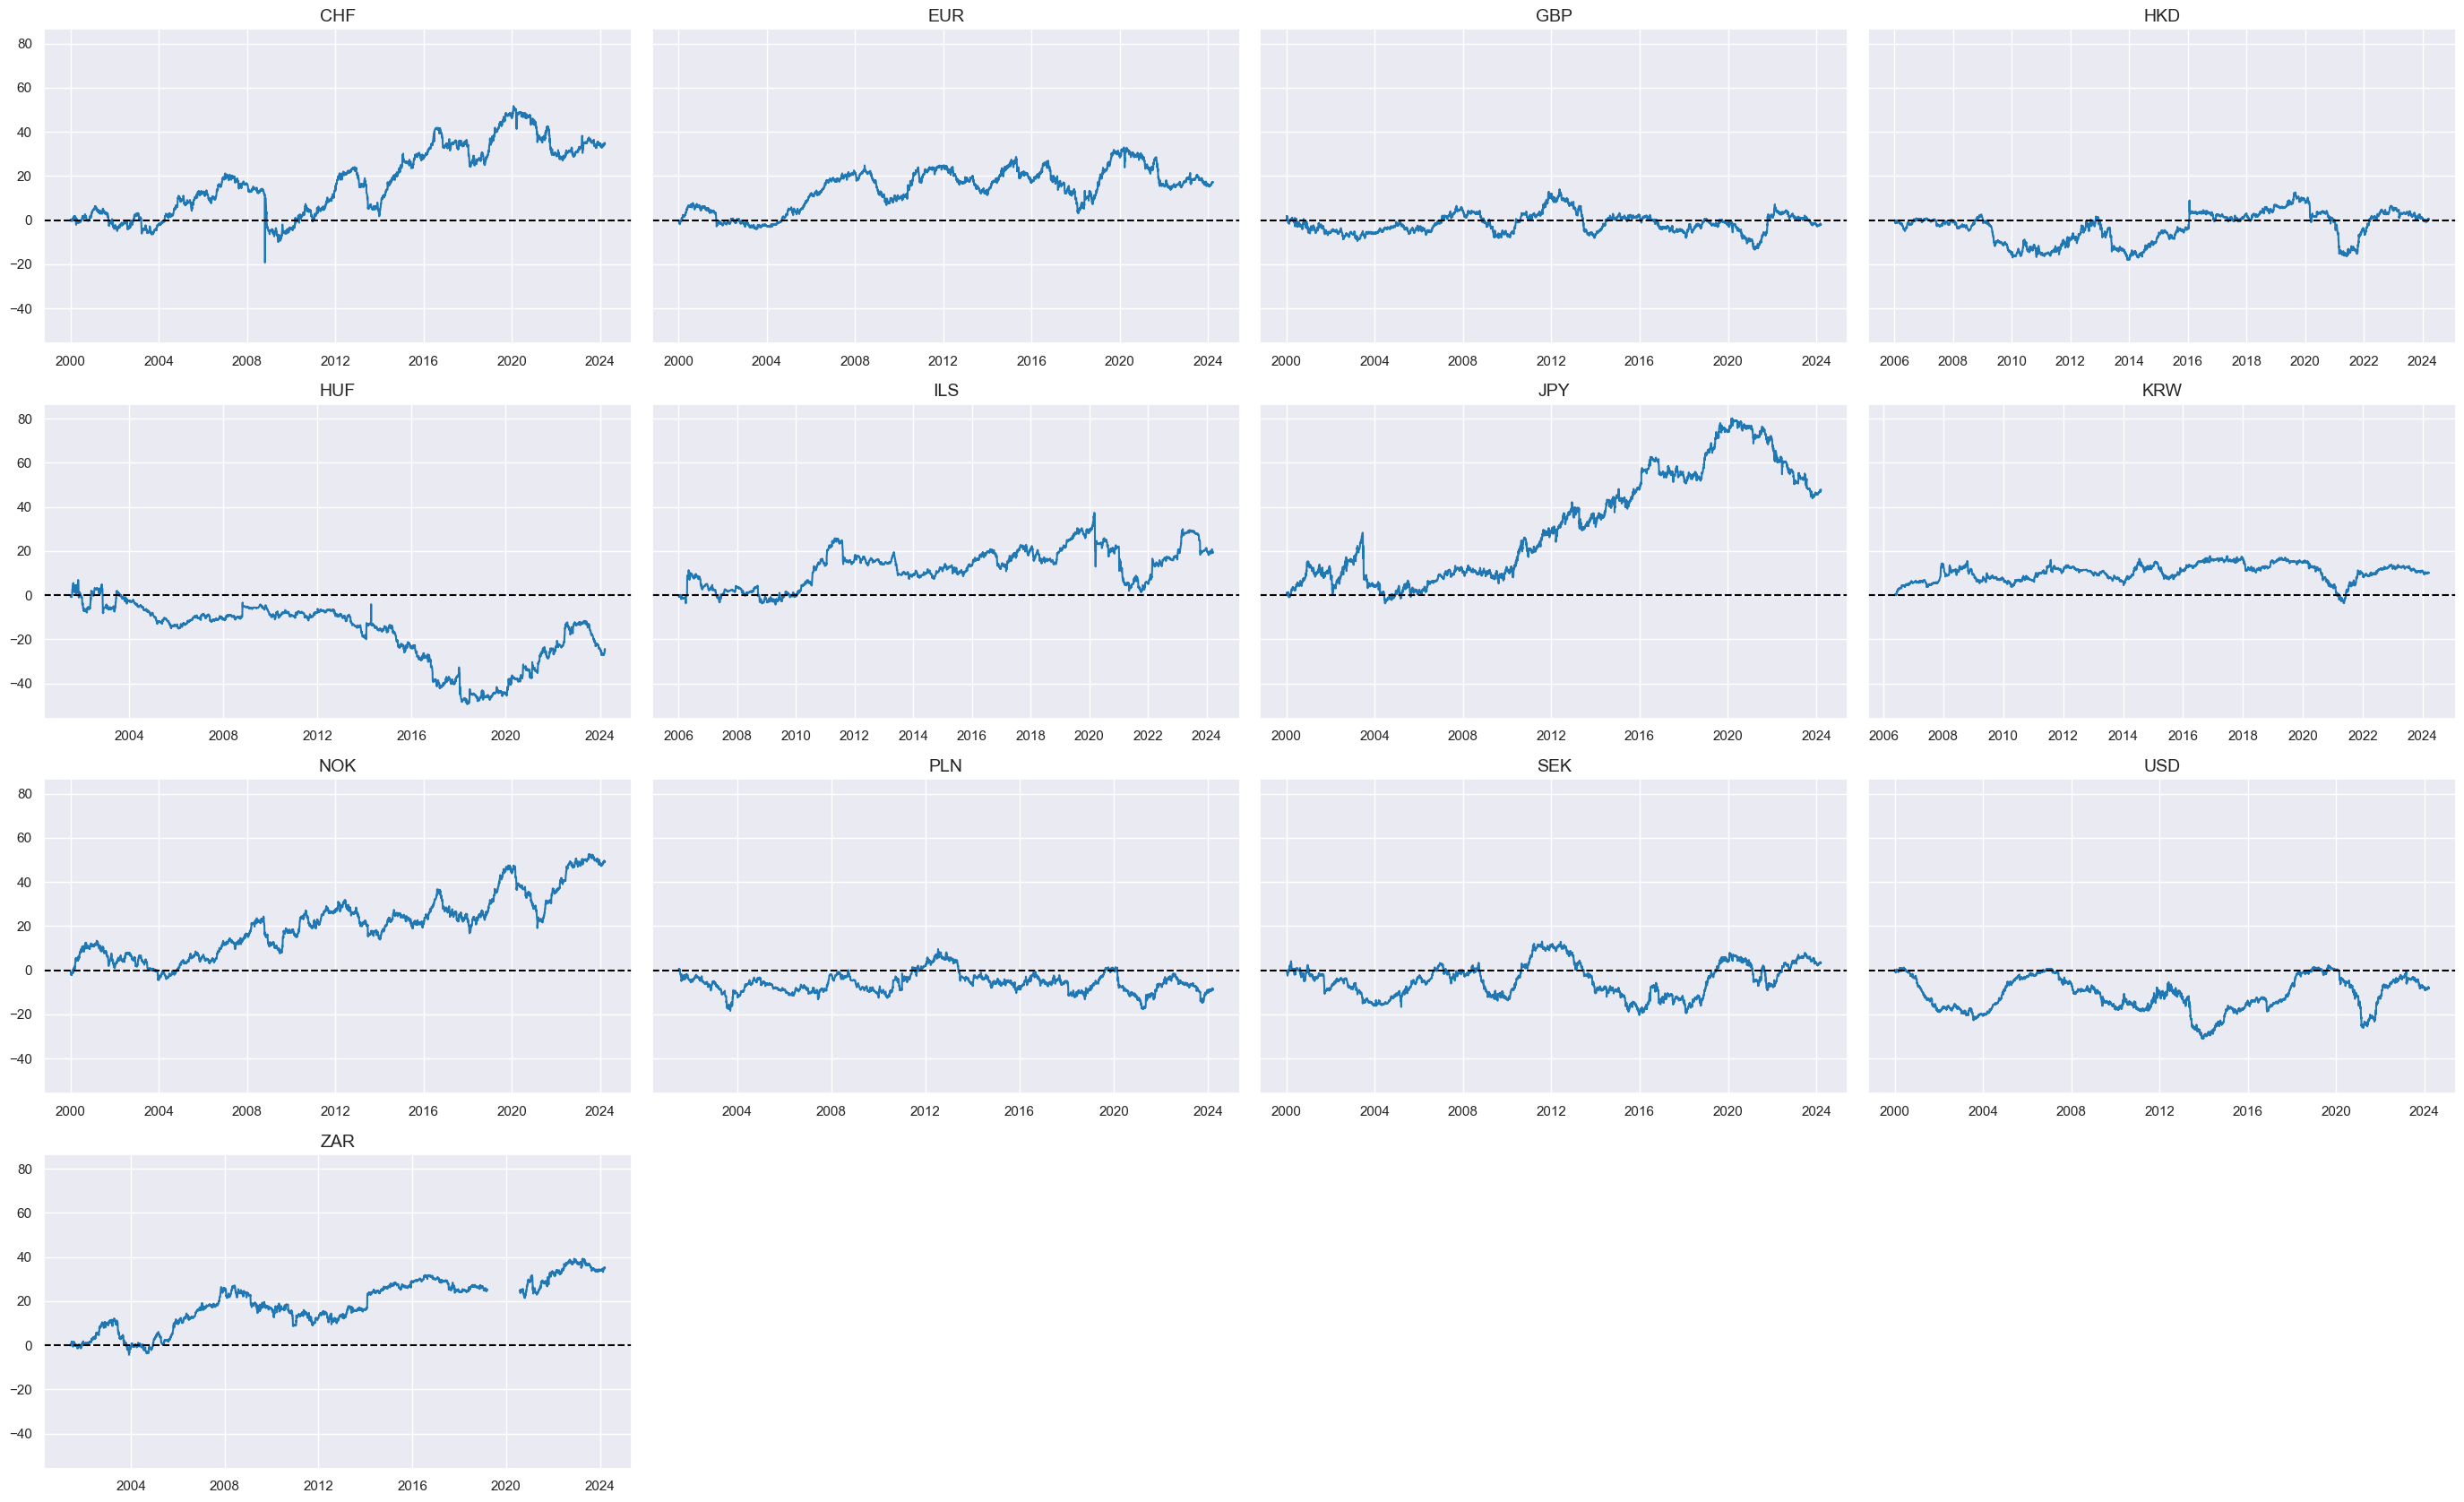

In [32]:
xcats_sel = ["DU5v2YXR"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_vrp,
    ncol=4,
    cumsum=True,
    start="2000-01-01",
    same_y=True,
    size=(12, 12),
    all_xticks=True,
    title=None,
    xcat_labels=None,
)

Curve trade returns have generally been positively correlated across currency areas.

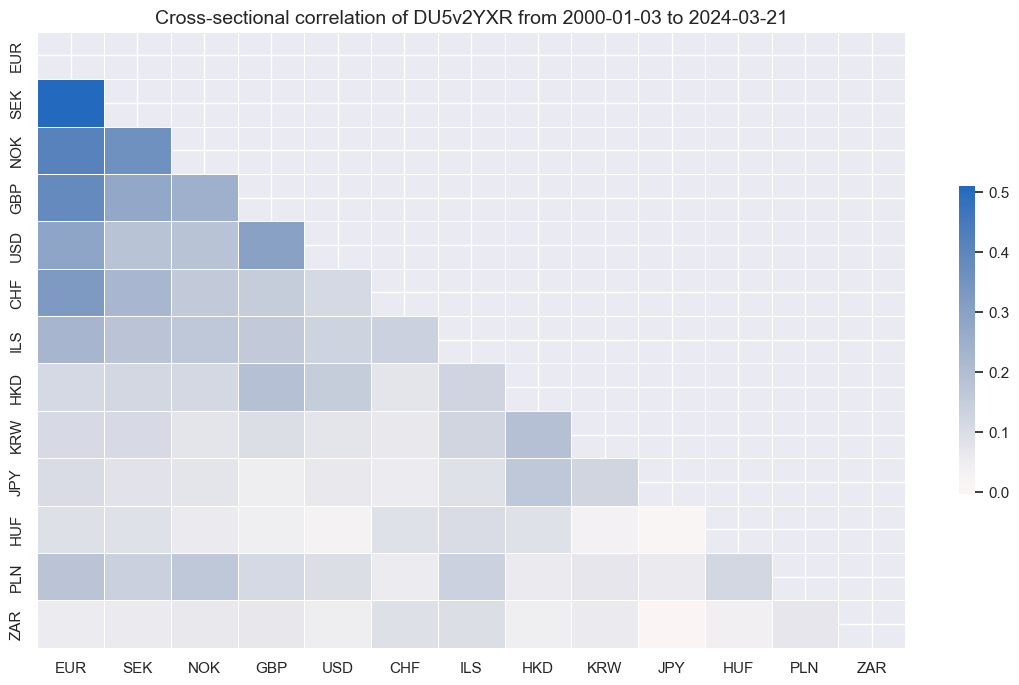

In [33]:
msp.correl_matrix(
    dfx, xcats="DU5v2YXR", cids=cids_vrp, start="2000-01-01", cluster=True
)

Most currency areas' receiver positions have outperformed the USD IRS receivers over the long term.

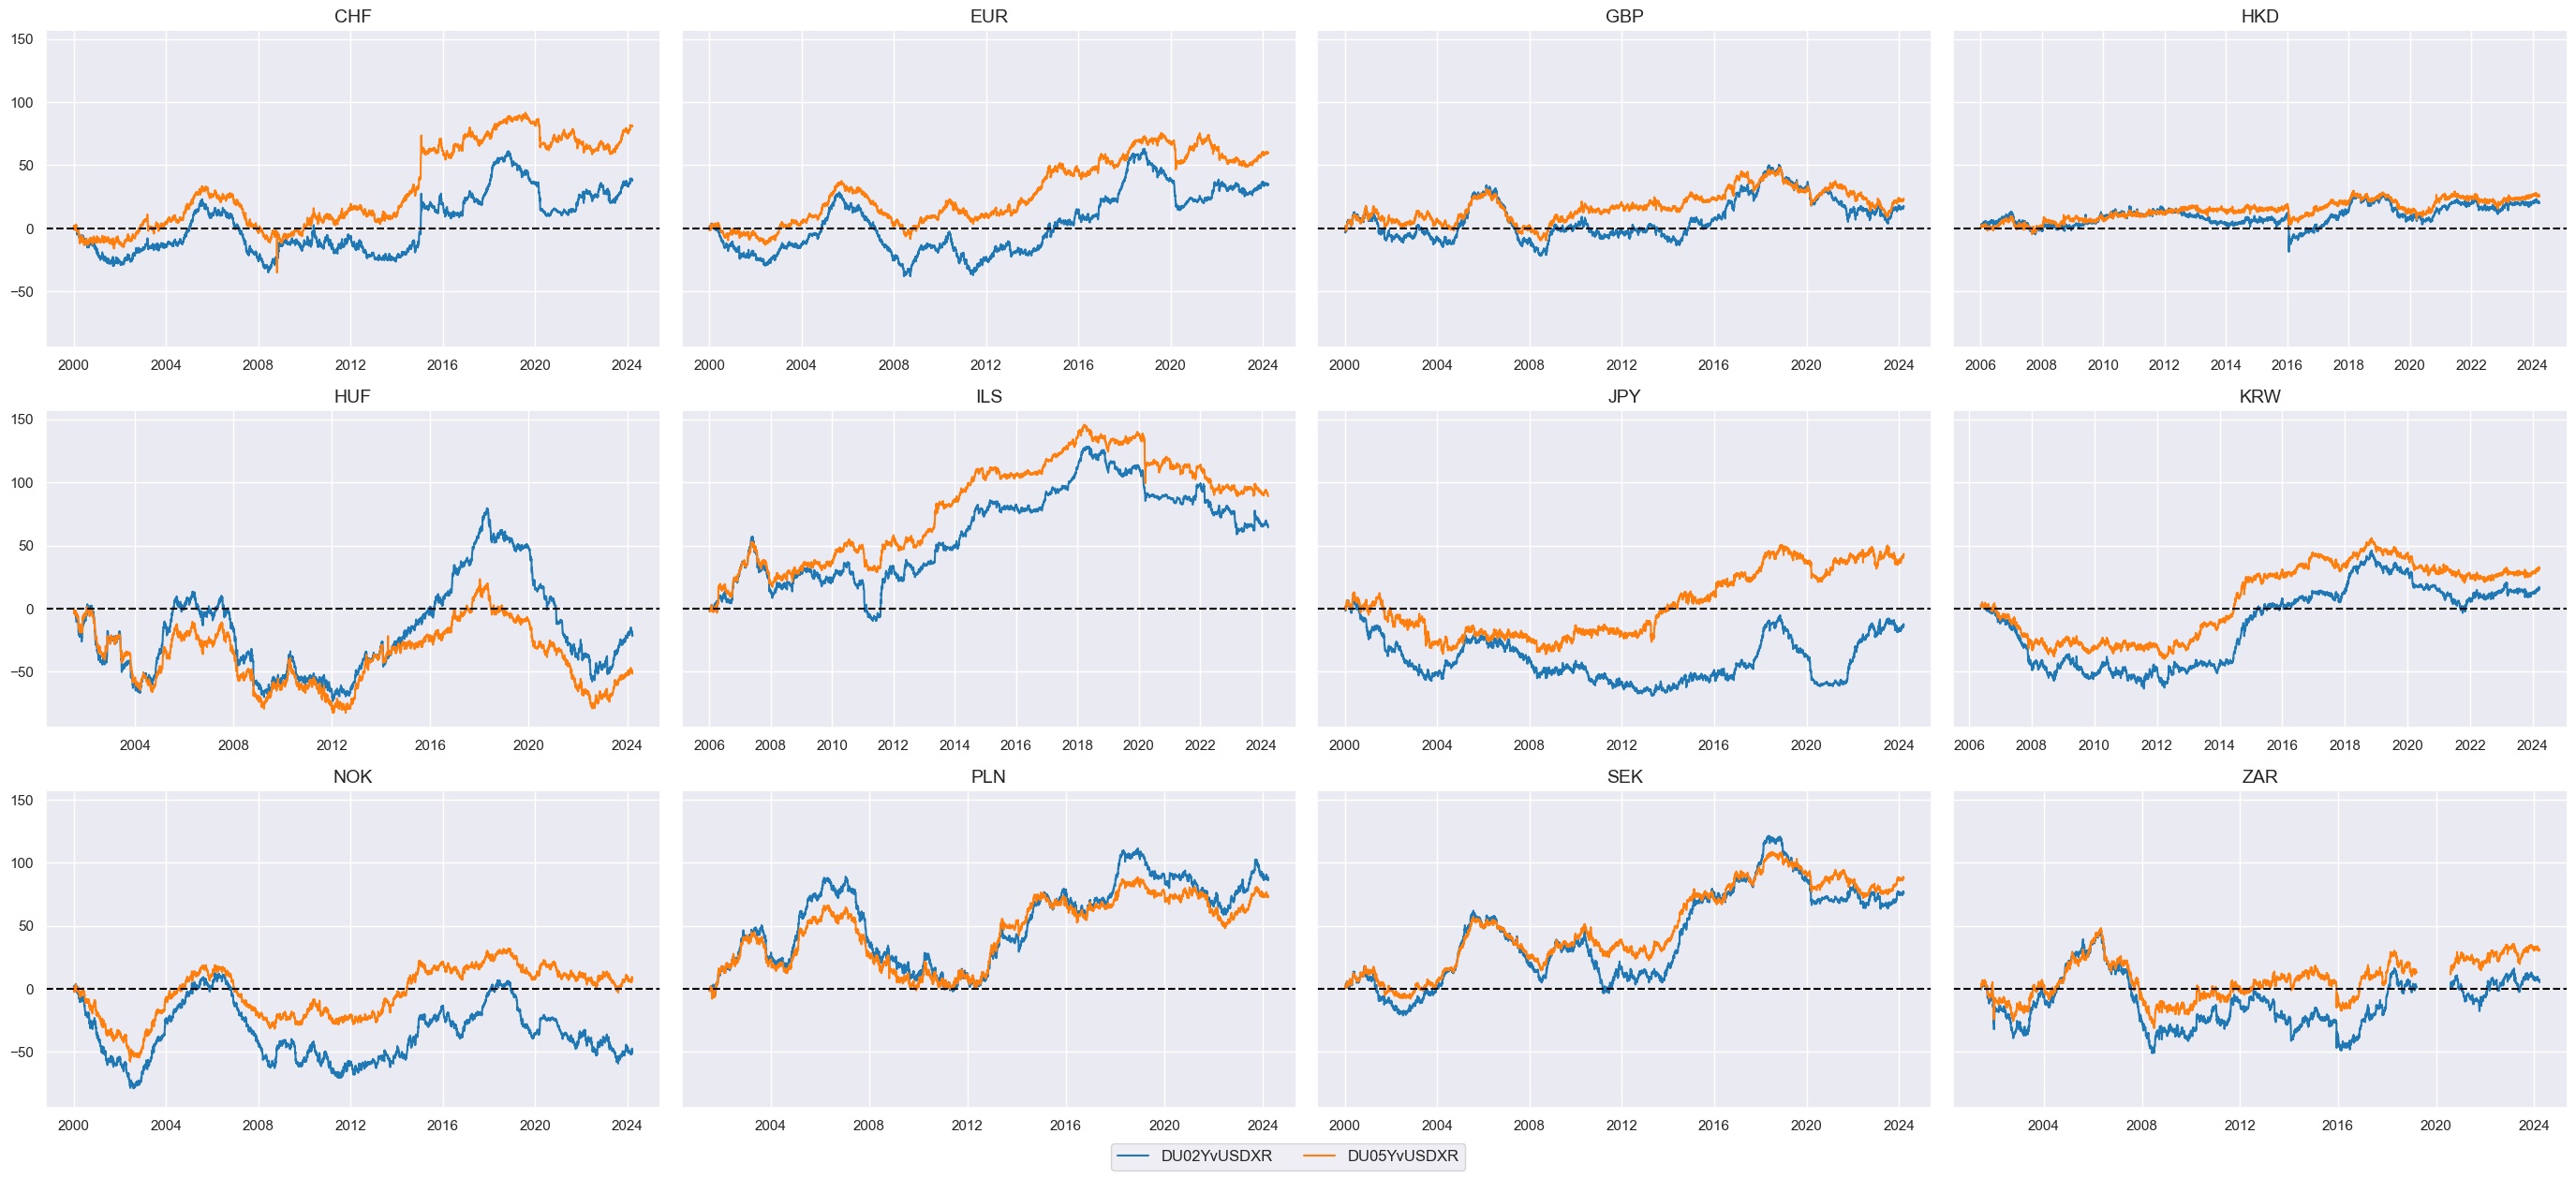

In [34]:
xcats_sel = ["DU02YvUSDXR", "DU05YvUSDXR"]
msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_vrxu,
    ncol=4,
    cumsum=True,
    start="2000-01-01",
    same_y=True,
    size=(12, 12),
    all_xticks=True,
    title=None,
    xcat_labels=None,
)

## Value checks

### VRP and directional returns

There has been no clear relation between duration VRP and subsequent IRS returns. Higher premia on volatility risk have not translated into higher returns on outright duration exposure. The correlation coefficient is around 0. Using "map" as prob_est instead of the default "pool" diminishes the significance probability further. For details on the test please see [Testing macro trading factors](https://research.macrosynergy.com/testing-macro-trading-factors/). Since we see almost no correlation between VRP and directional returns, we will not construct a trading strategy based on simple VRP, instead, we proceed with the investigation of the two derived concepts, term and maturity spreads, on subsequent returns.

IRVRP_5DMA_AVG misses: ['HKD', 'HUF', 'KRW'].


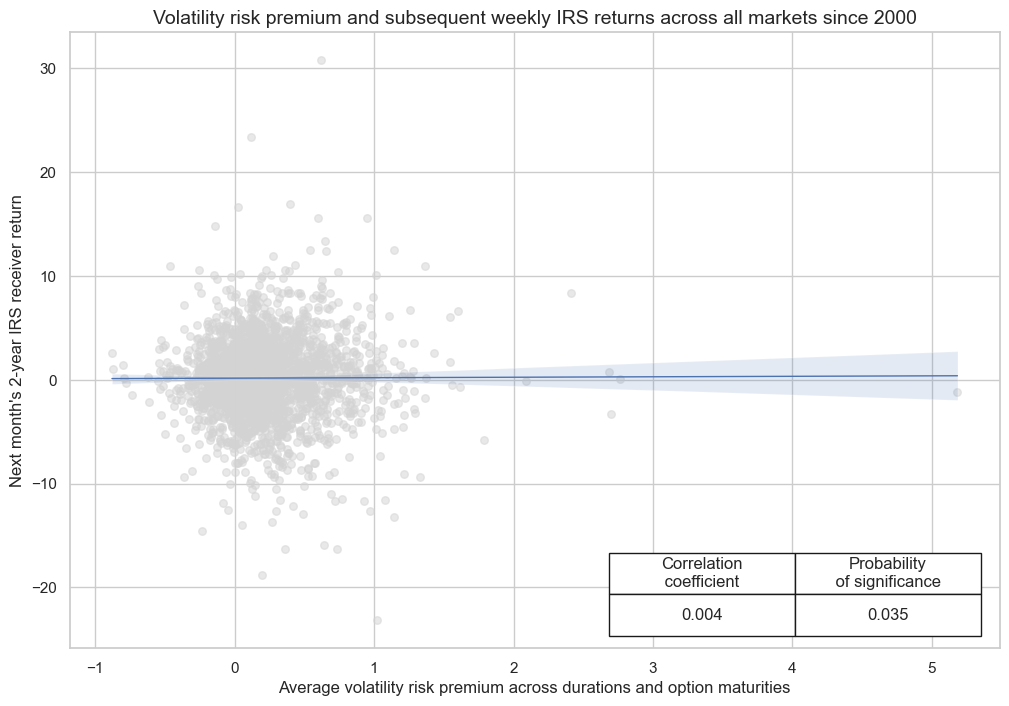

In [35]:
xcats_vpa_2vt = ["IRVRP_5DMA_AVG", "DU02YXR_VT10"]
xcats_sel = xcats_vpa_2vt
cids_sel = cids_vrp
cr = msp.CategoryRelations(
    dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    xcat_trims=[None, None],
)
cr.reg_scatter(
    labels=False,
    prob_est="map",
    coef_box="lower right",
    title="Volatility risk premium and subsequent weekly IRS returns across all markets since 2000",
    xlab="Average volatility risk premium across durations and option maturities",
    ylab="Next month's 2-year IRS receiver return",
)

### VRP and relative returns

The correlation of volatility risk premia in non-U.S. markets with subsequent IRS receiver returns relative to the U.S. has been positive with modest significance. This suggests that premia are charged for idiosyncratic volatility risk and predictive for idiosyncratic returns in non-USD currency areas.
However, if the test is run using time-specific random effects estimation method, the significance goes down further.

IRVRP_5DMA_AVG misses: ['HKD', 'HUF', 'KRW'].


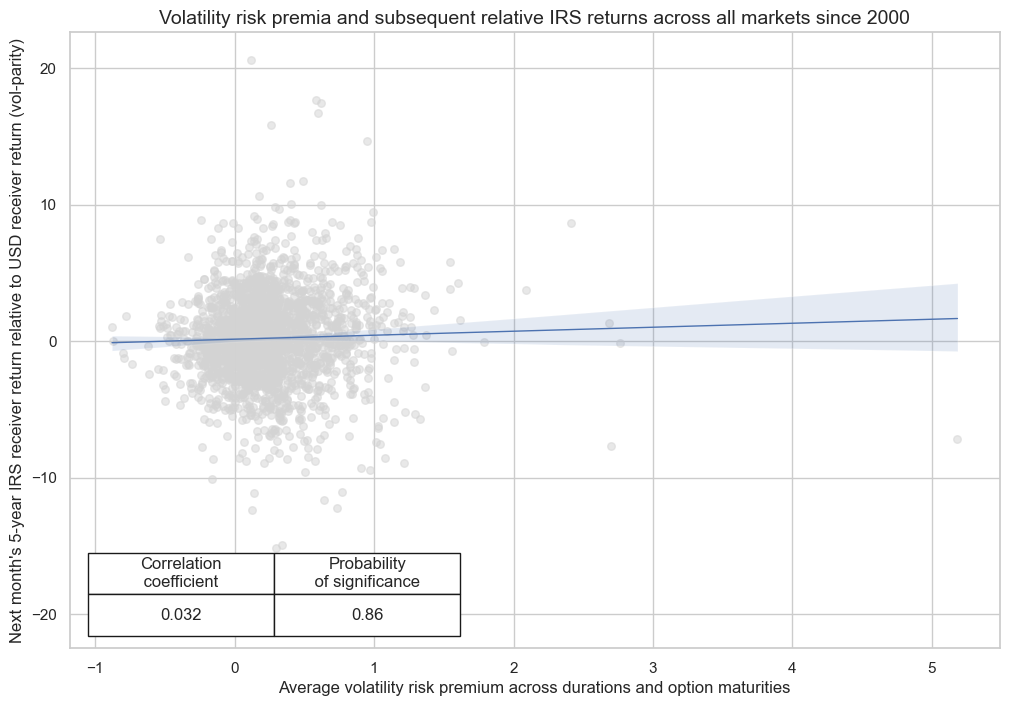

In [36]:
xcats_vpa_5vu = ["IRVRP_5DMA_AVG", "DU05YvUSDXR"]
xcats_sel = xcats_vpa_5vu
cids_sel = cids_vrxu
cr = msp.CategoryRelations(
    dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    xcat_trims=[None, None],
    blacklist=dv_black,
)
cr.reg_scatter(
    labels=False,
    coef_box="lower left",
    title="Volatility risk premia and subsequent relative IRS returns across all markets since 2000",
    xlab="Average volatility risk premium across durations and option maturities",
    ylab="Next month's 5-year IRS receiver return relative to USD receiver return (vol-parity)",
)

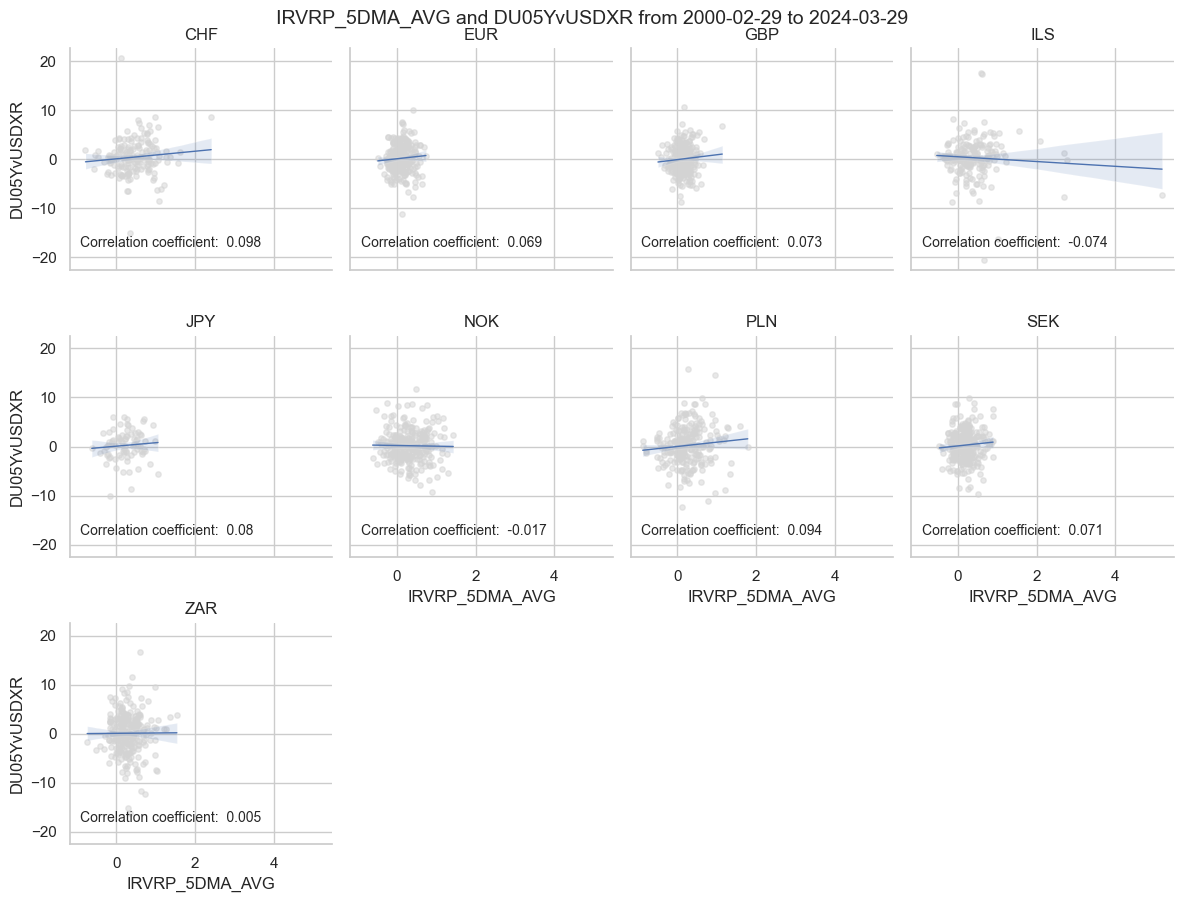

In [37]:
cr.reg_scatter(
    labels=False,
    coef_box="lower left",
    title=None,
    xlab=None,
    ylab=None,
    separator="cids",
)

 We use `SignalReturnRelations()` function from the [Macrosynergy package](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations), which analyses and compares the relationships between the chosen signals and the panel of subsequent returns. There is no regression analysis involved, rather the sign of the signal is used for predicting the sign of the target.

In [38]:
xcats_sel = xcats_vpa_5vu
cids_sel = cids_vrxu
srr = mss.SignalReturnRelations(
    dfx,
    cids=cids_sel,
    sigs=xcats_sel[0],
    rets=xcats_sel[1],
    freqs="W",
    start="2000-01-01",
    blacklist=dv_black,
)

In [39]:
display(srr.summary_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  \
Panel              0.514         0.507     0.751     0.517     0.521   
Mean years         0.515         0.508     0.758     0.516     0.519   
Positive ratio     0.720         0.640     0.960     0.640     0.640   
Mean cids          0.514         0.506     0.755     0.517     0.521   
Positive ratio     0.889         0.667     1.000     1.000     1.000   

                neg_prec  pearson  pearson_pval  kendall  kendall_pval    auc  
Panel              0.494    0.001         0.913    0.006         0.362  0.506  
Mean years         0.497    0.000         0.363    0.007         0.372  0.505  
Positive ratio     0.440    0.480         0.320    0.480         0.360  0.640  
Mean cids          0.492    0.004         0.569    0.010         0.486  0.506  
Positive ratio     0.333    0.667         0.333    0.667         0.333  0.667

In [40]:
xcats_sel = xcats_vpa_5vu
cids_sel = cids_vrxu
start_date = "2000-01-01"
sigs = [xcats_sel[0]]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=xcats_sel[1],
    sigs=sigs,
    cids=cids_sel,
    start=start_date,
    blacklist=dv_black,
)

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_op="zn_score_pan",
        neutral="zero",
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "PZ0",
    )
    naive_pnl.make_pnl(
        sig,
        sig_op="zn_score_pan",
        neutral="mean",
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "PZM",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long")

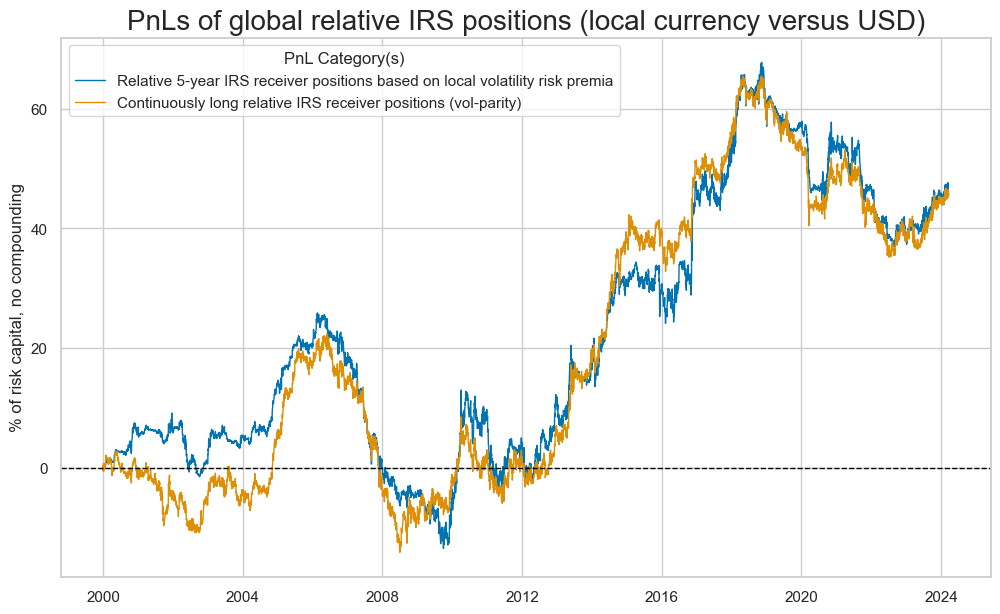

In [41]:
pnls = [xcats_sel[0] + "PZ0", "Long"]
dict_labels = {"IRVRP_5DMA_AVGPZ0": "Relative 5-year IRS receiver positions based on local volatility risk premia", "Long": "Continuously long relative IRS receiver positions (vol-parity)"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
    title="PnLs of global relative IRS positions (local currency versus USD)",
    xcat_labels=dict_labels,
)

### Term spreads and relative returns

There has been a positive correlation but due largely to size co-movement rather than high accuracy of directional predictions. 
Value generation would have been impressive, though, based on a standard generic strategy.

IRVRP_TS_5DMA_AVG misses: ['HKD', 'HUF', 'KRW'].


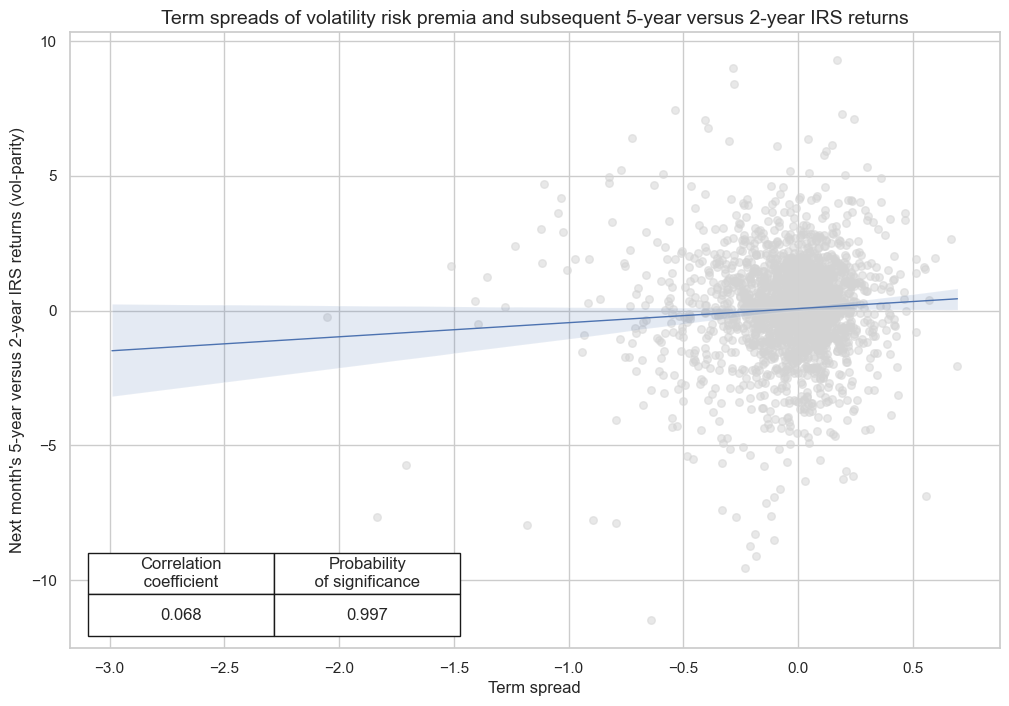

In [42]:
xcats_tsa_52 = ["IRVRP_TS_5DMA_AVG", "DU5v2YXR"]
xcats_sel = xcats_tsa_52
cids_sel = cids_vrp
cr = msp.CategoryRelations(
    dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    xcat_trims=[None, None],
)
cr.reg_scatter(
    labels=False,
    coef_box="lower left",
    prob_est="map",
    title="Term spreads of volatility risk premia and subsequent 5-year versus 2-year IRS returns",
    xlab="Term spread",
    ylab="Next month's 5-year versus 2-year IRS returns (vol-parity)",
)

In [43]:
xcats_sel = xcats_tsa_52
cids_sel = cids_vrp
srr = mss.SignalReturnRelations(
    dfx,
    cids=cids_sel,
    sigs=xcats_sel[0],
    rets=xcats_sel[1],
    freqs="W",
    start="2000-01-01",
)

In [44]:
display(srr.summary_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  \
Panel              0.506         0.504     0.532     0.527     0.531   
Mean years         0.506         0.504     0.549     0.526     0.528   
Positive ratio     0.520         0.520     0.560     0.640     0.640   
Mean cids          0.500         0.502     0.486     0.530     0.526   
Positive ratio     0.600         0.500     0.500     1.000     0.900   

                neg_prec  pearson  pearson_pval  kendall  kendall_pval    auc  
Panel              0.477    0.038         0.000    0.006         0.376  0.504  
Mean years         0.479    0.026         0.375    0.008         0.418  0.504  
Positive ratio     0.240    0.680         0.520    0.560         0.400  0.520  
Mean cids          0.478    0.037         0.372    0.011         0.563  0.503  
Positive ratio     0.300    0.800         0.700    0.600         0.300  0.500

In [45]:
xcats_sel = xcats_tsa_52
cids_sel = cids_vrp
start_date = "2000-01-01"
sigs = [xcats_sel[0]]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=xcats_sel[1],
    sigs=sigs,
    cids=cids_sel,
    start=start_date,
    blacklist=dv_black,
)

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_op="zn_score_pan",
        neutral="zero",
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "PZ0",
    )
    naive_pnl.make_pnl(
        sig,
        sig_op="zn_score_pan",
        neutral="mean",
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "PZM",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long")

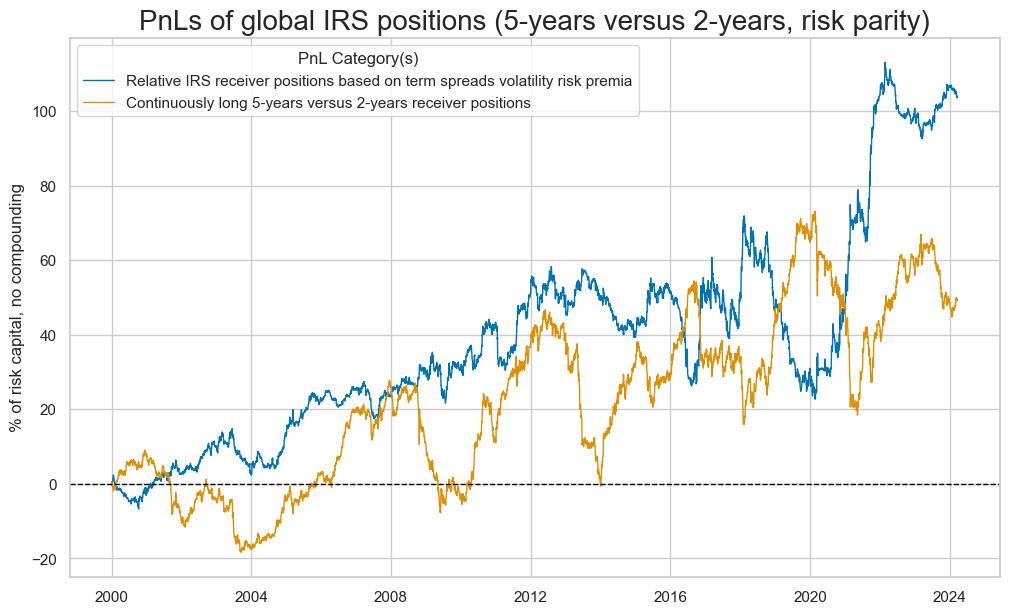

In [46]:
pnls = [xcats_sel[0] + "PZ0", "Long"]
start_date = "2000-01-01"
dict_labels = {"IRVRP_TS_5DMA_AVGPZ0": "Relative IRS receiver positions based on term spreads volatility risk premia", 
               "Long": "Continuously long 5-years versus 2-years receiver positions"}


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
    title="PnLs of global IRS positions (5-years versus 2-years, risk parity)",
    xcat_labels=dict_labels,
)

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
)

In [47]:
display(df_eval)

xcat              IRVRP_TS_5DMA_AVGPZ0       Long
Return (pct ar)               4.280303   2.038829
St. Dev. (pct ar)                 10.0       10.0
Sharpe Ratio                   0.42803   0.203883
Sortino Ratio                 0.663843   0.277556
Max 21-day draw             -11.591743 -23.407636
Max 6-month draw            -28.352643 -33.419888
Traded Months                      291        291

### Maturity spreads and directional returns

There has been a mild positive correlation between maturity spreads and subsequent duration returns. The drawback as a trading signal is mainly the almost 70% short bias. Part of the short bias relates to the unexploited mean reversion of realized duration volatility. 

IRVRP_MS_5DMA_AVG misses: ['HKD', 'HUF', 'KRW'].


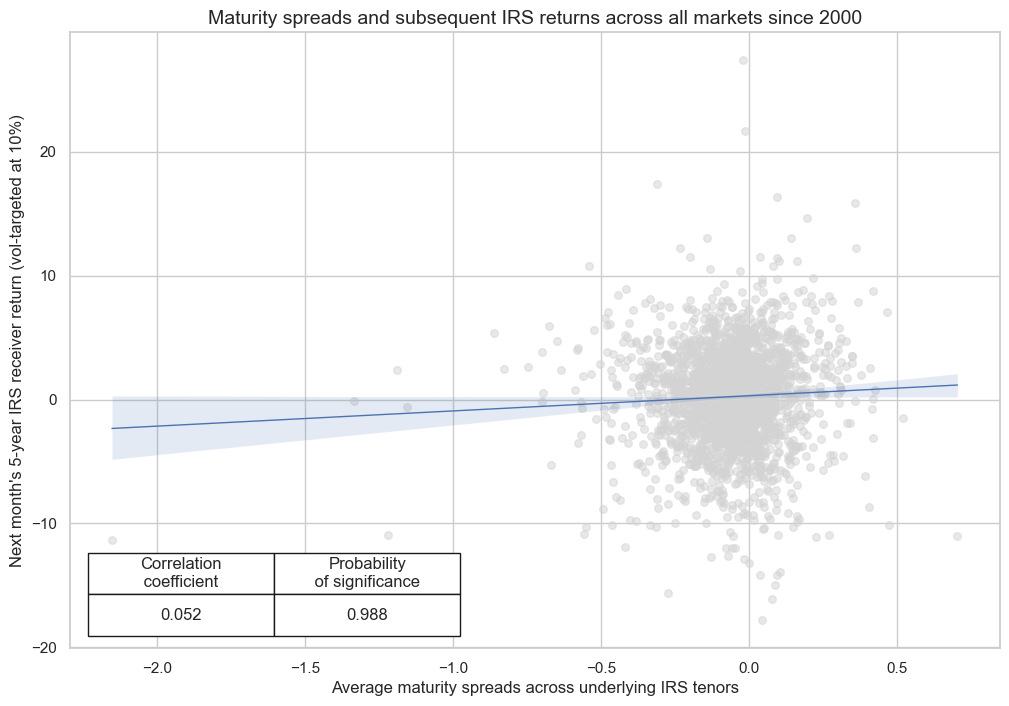

In [48]:
xcats_msa_2vt = ["IRVRP_MS_5DMA_AVG", "DU05YXR_VT10"]
xcats_sel = xcats_msa_2vt
cids_sel = cids_vrp
cr = msp.CategoryRelations(
    dfx,
    xcats=xcats_sel,
    cids=cids_sel,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    xcat_trims=[None, None],
)
cr.reg_scatter(
    labels=False,
    coef_box="lower left",
    title="Maturity spreads and subsequent IRS returns across all markets since 2000",
    xlab="Average maturity spreads across underlying IRS tenors",
    ylab="Next month's 5-year IRS receiver return (vol-targeted at 10%)",
)

In [49]:
xcats_sel = xcats_msa_2vt
cids_sel = cids_vrp
srr = mss.SignalReturnRelations(
    dfx,
    cids=cids_sel,
    sigs=xcats_sel[0],
    rets=xcats_sel[1],
    freqs="W",
    start="2000-01-01",
)

In [50]:
display(srr.summary_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  \
Panel              0.491         0.506     0.321     0.540     0.549   
Mean years         0.496         0.504     0.325     0.542     0.546   
Positive ratio     0.400         0.480     0.160     0.760     0.640   
Mean cids          0.488         0.496     0.312     0.540     0.529   
Positive ratio     0.400         0.500     0.100     1.000     0.900   

                neg_prec  pearson  pearson_pval  kendall  kendall_pval    auc  
Panel              0.464    0.029         0.004    0.013         0.041  0.506  
Mean years         0.462    0.013         0.377    0.005         0.423  0.503  
Positive ratio     0.200    0.480         0.320    0.520         0.240  0.480  
Mean cids          0.464    0.011         0.413    0.006         0.409  0.503  
Positive ratio     0.000    0.700         0.500    0.700         0.500  0.500

A simple strategy that uses only the maturity spread (z-score around zero) as a signal for receiver versus payer position would not have created much positive PnL over the past 22 years. This is due mainly to its strong short-duration bias. Since, in stable monetary regimes, there is not much “escalation risk premium” on offer, the signal would have been negative in almost 70% of all weeks across all countries. The signal would have implied a massive short duration risk bias.

In [51]:
xcats_sel = xcats_msa_2vt
cids_sel = cids_vrp
start_date = "2000-01-01"
sigs = [xcats_sel[0]]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=xcats_sel[1],
    sigs=sigs,
    cids=cids_sel,
    start=start_date,
)

for sig in sigs:
    naive_pnl.make_pnl(
        sig,
        sig_op="zn_score_pan",
        neutral="zero",
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "PZ0",
    )
    naive_pnl.make_pnl(
        sig,
        sig_op="zn_score_pan",
        neutral="mean",
        thresh=2,
        rebal_freq="weekly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "PZM",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long")

The chart illustrates that positive correlation and predictive power alone are not enough to make a good directional positioning signal. The signal must also set the right long-term bias and gather a critical mass of explanatory power for all the premia charged on a contract. The maturity spread, which reflects a single type of risk premium, cannot provide that. As with many short risk-bias strategies, its own overall performance as a trading signal is not impressive. However, it is a valid contributor to signal for directional exposure to duration risk.

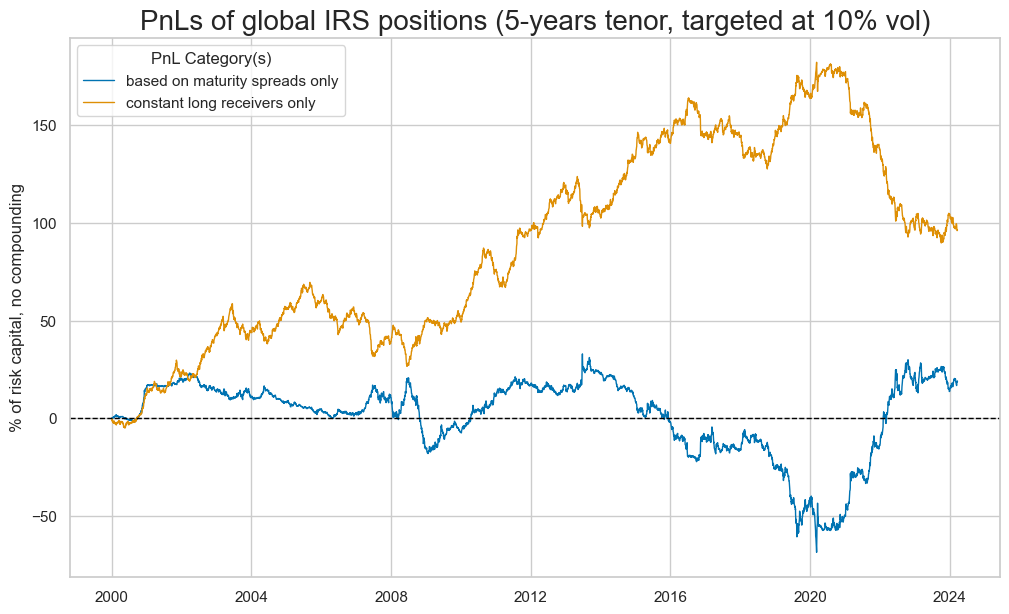

In [52]:
pnls = [xcats_sel[0] + "PZ0", "Long"]
dict_labels = {"IRVRP_MS_5DMA_AVGPZ0": "based on maturity spreads only", 
               "Long": "constant long receivers only"}


naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
    title="PnLs of global IRS positions (5-years tenor, targeted at 10% vol)",
    xcat_labels=dict_labels,
)
df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start_date,
)

In [53]:
display(df_eval)

xcat              IRVRP_MS_5DMA_AVGPZ0       Long
Return (pct ar)               0.787395    3.97491
St. Dev. (pct ar)                 10.0       10.0
Sharpe Ratio                  0.078739   0.397491
Sortino Ratio                 0.115315    0.55272
Max 21-day draw             -20.419992 -19.439062
Max 6-month draw            -35.751574 -39.144904
Traded Months                      291        291

In [54]:
xcats_sel = xcats_tsa_52
cids_sel = ["USD"]
srr = mss.SignalReturnRelations(
    dfx,
    cids=cids_sel,
    sigs=xcats_sel[0],
    rets=xcats_sel[1],
    freqs="W",
    start="1992-01-01",
)

In [55]:
display(srr.summary_table().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  pos_prec  \
Panel              0.531         0.527     0.709     0.520     0.536   
Mean years         0.529         0.542     0.718     0.520     0.530   
Positive ratio     0.576         0.576     0.697     0.576     0.667   
Mean cids          0.531         0.527     0.709     0.520     0.536   
Positive ratio     1.000         1.000     1.000     1.000     1.000   

                neg_prec  pearson  pearson_pval  kendall  kendall_pval    auc  
Panel              0.518    0.069         0.005    0.029         0.074  0.522  
Mean years         0.506    0.029         0.520    0.018         0.587  0.513  
Positive ratio     0.455    0.606         0.333    0.576         0.182  0.545  
Mean cids          0.518    0.069         0.005    0.029         0.074  0.522  
Positive ratio     1.000    1.000         1.000    1.000         1.000  1.000